This notebook contains notes and code taken from the book Build a Large Language Model (From Scratch) written by Sebastian Raschka.

I include notes comming directly from book and information from other sources.

I start my notes from Chapter 2 since the first one has concepts and no code.

# Data loading

Retrieving a text from original github repo.

In [1]:
import urllib.request

url = 'https://raw.githubusercontent.com/rasbt/LLMs-from-scratch/main/ch02/01_main-chapter-code/the-verdict.txt'
file_path = 'the-verdict.txt'
urllib.request.urlretrieve(url, file_path)

('the-verdict.txt', <http.client.HTTPMessage at 0x7e865882b910>)

In [2]:
with open(file_path, 'r', encoding='utf-8') as f:
    raw_text = f.read()

print("Total number of character: ", len(raw_text))
print(raw_text[:99])

Total number of character:  20479
I HAD always thought Jack Gisburn rather a cheap genius--though a good fellow enough--so it was no 


# Tokenization

Using `re` library to tokenize the text. The regular expression is based on splitting it by `,`, `.` and whitespace. However, the first 100 characters shown in the previous steps had double dash and, supposing it also contains other special characters like question marks and quotation marks, the regular expression suffer a modification to handle them.

In [3]:
import re

text = "Hello, world. This, is a test."
result = re.split(r"([,.]|\s)", text)
print("Raw tokenization")
print(result)

result = [item for item in result if item.strip()]
print("Tokenization removing whitespaces")
print(result)

Raw tokenization
['Hello', ',', '', ' ', 'world', '.', '', ' ', 'This', ',', '', ' ', 'is', ' ', 'a', ' ', 'test', '.', '']
Tokenization removing whitespaces
['Hello', ',', 'world', '.', 'This', ',', 'is', 'a', 'test', '.']


In [4]:
text = 'Hello, world. Is this--  a test?'
result = re.split(r'([,.:;?_!"()\']|--|\s)', text)
result = [item.strip() for item in result if item.strip()]
print(result)

['Hello', ',', 'world', '.', 'Is', 'this', '--', 'a', 'test', '?']


## Handling the actual text

Once refined the tokenization method, the next step is tokenize the actual text by using the expression previously defined.

At the first block it's easy to see that there are only 4,690 tokens and at the second block the first 31 tokens reveal that the tokenization process works well.

In [5]:
preprocessed = re.split(r'([,.:;?_!"()\']|--|\s)', raw_text)
preprocessed = [item.strip() for item in preprocessed if item.strip()]
print(len(preprocessed))

4690


In [6]:
print(preprocessed[:30])

['I', 'HAD', 'always', 'thought', 'Jack', 'Gisburn', 'rather', 'a', 'cheap', 'genius', '--', 'though', 'a', 'good', 'fellow', 'enough', '--', 'so', 'it', 'was', 'no', 'great', 'surprise', 'to', 'me', 'to', 'hear', 'that', ',', 'in']


## Tokens into IDs

This steps converts the text into an integer representation assigning an integer to each token by building a vocabulary. The vocabulary is a map where each unique word and special character to a unique integer.

In [7]:
all_words = sorted(set(preprocessed))
vocab_size = len(all_words)
print(vocab_size)

1130


In [8]:
vocab = {token: integer for integer, token in enumerate(all_words)}
for i, item in enumerate(vocab.items()):
    print(item)
    if i >= 50:
        break

('!', 0)
('"', 1)
("'", 2)
('(', 3)
(')', 4)
(',', 5)
('--', 6)
('.', 7)
(':', 8)
(';', 9)
('?', 10)
('A', 11)
('Ah', 12)
('Among', 13)
('And', 14)
('Are', 15)
('Arrt', 16)
('As', 17)
('At', 18)
('Be', 19)
('Begin', 20)
('Burlington', 21)
('But', 22)
('By', 23)
('Carlo', 24)
('Chicago', 25)
('Claude', 26)
('Come', 27)
('Croft', 28)
('Destroyed', 29)
('Devonshire', 30)
('Don', 31)
('Dubarry', 32)
('Emperors', 33)
('Florence', 34)
('For', 35)
('Gallery', 36)
('Gideon', 37)
('Gisburn', 38)
('Gisburns', 39)
('Grafton', 40)
('Greek', 41)
('Grindle', 42)
('Grindles', 43)
('HAD', 44)
('Had', 45)
('Hang', 46)
('Has', 47)
('He', 48)
('Her', 49)
('Hermia', 50)


## Tokenizer

To tokenizer in a simplier form, it's created a `SimpleTokenizerV1` class. It takes a vocabulary and creates an inverse one to correctly maps the IDs into tokens.

The motivation behind it is that once the LLM is trained with the IDs, the model will return integer IDs, not text. To interpretate the LLM resuls the class implements a decode method that will map the IDs into strings.

>Note: The tokenizer works well on known words (i.e. words inside the vocabulary). If a new word is presetend to the tokenizer, it will produce an error since there new word has no ID associated.

In [9]:
class SimpleTokenizerV1:

    def __init__(self, vocab):
        # stores the vocabulary
        self.str_to_int = vocab
        # Inverse vocabulary that maps token IDs back to the original text tokens
        self.int_to_str = {i:s for s,i in vocab.items()}

    def encode(self, text):
        # Processes input text into token IDs
        preprocessed = re.split(r'([,.:;?_!"()\']|--|\s)', text)
        preprocessed = [item.strip() for item in preprocessed if item.strip()]
        ids = [self.str_to_int[s] for s in preprocessed]
        return ids

    def decode(self, ids):
        # Converts token IDs back into text
        text = " ".join([self.int_to_str[i] for i in ids])
        # Removes spaces before the specified punctuation
        text = re.sub(r'\s+([,.?!"()\'])', r'\1', text)
        return text

In [10]:
tokenizer = SimpleTokenizerV1(vocab)
text = """
It's the last he painted, you know, " Mrs. Gisburn said with pardonable pride.
"""
ids = tokenizer.encode(text)
print(ids)

[56, 2, 850, 988, 602, 533, 746, 5, 1126, 596, 5, 1, 67, 7, 38, 851, 1108, 754, 793, 7]


In [11]:
print(tokenizer.decode(ids))

It' s the last he painted, you know," Mrs. Gisburn said with pardonable pride.


## Context tokens

To improve the `SimpleTokenizerV1` it's time to introduce two new context tokens.

1. `<|unk|>` this will be used when words that where not part of the training are introduced to the tokenizer.
2. `<|endoftext|>` token that will be used to separate two unrelated text sources.

As mentioned, the first one will be useful to represent unseen words. While the second one will help the LLM to understand that in fact multiple text sources are concatenated for training, they are unrelated.

In [12]:
all_tokens = sorted(list(set(preprocessed)))
all_tokens.extend(["<|endoftext|>","<|unk|>"])
vocab = {token: integer for integer,token in enumerate(all_tokens)}

print(len(vocab.items()))

1132


In [13]:
for i, item in enumerate(list(vocab.items())[-5:]):
    print(item)

('younger', 1127)
('your', 1128)
('yourself', 1129)
('<|endoftext|>', 1130)
('<|unk|>', 1131)


In [14]:
class SimpleTokenizerV2:

    def __init__(self, vocab):
        # stores the vocabulary
        self.str_to_int = vocab
        # Inverse vocabulary that maps token IDs back to the original text tokens
        self.int_to_str = {i:s for s,i in vocab.items()}

    def encode(self, text):
        # Processes input text into token IDs
        preprocessed = re.split(r'([,.:;?_!"()\']|--|\s)', text)
        preprocessed = [item.strip() for item in preprocessed if item.strip()]
        # Replaces unkown words by <|unk|> tokens
        preprocessed = [item if item in self.str_to_int else "<|unk|>" for item in preprocessed]
        ids = [self.str_to_int[s] for s in preprocessed]
        return ids

    def decode(self, ids):
        # Converts token IDs back into text
        text = " ".join([self.int_to_str[i] for i in ids])
        # Removes spaces before the specified punctuation
        text = re.sub(r'\s+([,.?!"()\'])', r'\1', text)
        return text

In [15]:
# In this example, Hello and palace are not part of the training dataset, therefore the tokenizer assign them the <|unk|> token

text1 = "Hello, do you like tea?"
text2 = "In the sunlit terraces of the palace."
text = "<|endoftext|> ".join((text1, text2))
print(text)

Hello, do you like tea?<|endoftext|> In the sunlit terraces of the palace.


In [16]:
tokenizer = SimpleTokenizerV2(vocab)
print(tokenizer.encode(text))

[1131, 5, 355, 1126, 628, 975, 10, 1130, 55, 988, 956, 984, 722, 988, 1131, 7]


In [17]:
print(tokenizer.decode(tokenizer.encode(text)))

<|unk|>, do you like tea? <|endoftext|> In the sunlit terraces of the <|unk|>.


## Byte Pairing Encoding (BPE)

BPE is a tokenizer that has several properties that outperforms classic tokenizers:

1. It is reversible
2. It works on arbitrary text
3. It compress the text
4. It attempts to let the model see common subwords

The algorithm breaks down words that aren't in its predefined vocabulary into smaller subword units or even individual characters, enabling it to handle out-of-vocabulary words.

In [18]:
import tiktoken

tokenizer = tiktoken.get_encoding('gpt2')

In [19]:
text = "Hello, do you like tea? <|endoftext|> In the sunlit terraces of someunkownPlace."

integers = tokenizer.encode(text, allowed_special={"<|endoftext|>"})
print(integers)

[15496, 11, 466, 345, 588, 8887, 30, 220, 50256, 554, 262, 4252, 18250, 8812, 2114, 286, 617, 2954, 593, 27271, 13]


In [20]:
string = tokenizer.decode(integers)
print(string)

Hello, do you like tea? <|endoftext|> In the sunlit terraces of someunkownPlace.


### Exercise 2.1 Byte pair encoding of unkown words

Trying BPE tokenizer from the tiktoken. I will call the encode method on the unknown words `Akwirw ier` and decode them one by one and all at once to see if the algorithm is capable of reconstruct the original input.

> Result: As mentioned before, the BPE algorithm encode the words depending on how many times a set of letters or words have been repeted in the text. This provice the algorithm information about the relevance and connectedness of letters or words inside a text. Providing it with capabilities like encoding unkown words.

In [21]:
# Encoding the unkown word
unk_word_int = tokenizer.encode('Akwirw ier')
print(unk_word_int)

[33901, 86, 343, 86, 220, 959]


In [22]:
# Then, decode it one ID at a time
for word_int in unk_word_int:
    print(tokenizer.decode([word_int]))

Ak
w
ir
w
 
ier


In [23]:
# Decode them all at once
tokenizer.decode(unk_word_int)

'Akwirw ier'

## Data sampling with a sliding window

Preparing the data for the first task that is word prediction, it's necessary to create some functionality that can split the data as the text goes on.

For example, if the text is `and established himself in`, then the preparation data to train a next word prediction should be something like this:

`and ----> established`
`and established ----> himself`
`and established himself in ---> a`

This text preparation is calles shifting, and the next cells will show how to do this.

In [24]:
# First, encoding the original text using tiktoken
enc_text = tokenizer.encode(raw_text)
print(len(enc_text))

5145


In [25]:
# Then, removing the first 50 tokens
enc_sample = enc_text[50:]

In [26]:
# Now, using a context size (a sampling window), a representation of value and prediction is shown
# (shifting the original text 1 space to the right)
context_size = 4
x = enc_sample[:context_size]
y = enc_sample[1:context_size + 1]
print(f"x: {x}")
print(f"y:      {y}")

x: [290, 4920, 2241, 287]
y:      [4920, 2241, 287, 257]


In [27]:
# Then, combine the idea into a loop so the sample is shifted
# Here, the tokens after the arrow (--->) represents the desired output
# While the tokens before it, represents the input.
for i in range(1, context_size+1):
    context = enc_sample[:i]
    desired = enc_sample[i]
    print(context, "---->", desired)

[290] ----> 4920
[290, 4920] ----> 2241
[290, 4920, 2241] ----> 287
[290, 4920, 2241, 287] ----> 257


In [28]:
# This last step is using the decoded tokens
for i in range(1, context_size + 1):
    context = enc_sample[:i]
    desired = enc_sample[i]
    print(tokenizer.decode(context), "---->", tokenizer.decode([desired]))

 and ---->  established
 and established ---->  himself
 and established himself ---->  in
 and established himself in ---->  a


## Data loader

Now that the logic is clear, here a Data loader is created. This class purpose is to shift the original text by 1 position while representing it as a tensor.

After the class, there is a function that uses the data loader to generate batches with input-with pairs.

In [29]:
import torch
from torch.utils.data import Dataset, DataLoader
class GPTDatasetV1(Dataset):
    def __init__(self, txt, tokenizer, max_length, stride):
        self.input_ids = []
        self.target_ids = []

        # Tokenizes the entire text
        token_ids = tokenizer.encode(txt)
        for i in range(0, len(token_ids) - max_length, stride):
            # Uses a sliding window to chunk the book into overlapping sequences of max_length
            input_chunk = token_ids[i:i + max_length]
            target_chunk = token_ids[i + 1: i + max_length + 1]

            self.input_ids.append(torch.tensor(input_chunk))
            self.target_ids.append(torch.tensor(target_chunk))

    def __len__(self):
        # Returns the total number of rows in the dataset
        return len(self.input_ids)

    def __getitem__(self, idx):
        # Returns a single row from the dataset
        return self.input_ids[idx], self.target_ids[idx]

In [30]:
def create_dataloader_v1(txt, batch_size=4, max_length=256, 
                         stride=128, shuffle=True, drop_last=True, num_workers=0):
    # Initializes the tokenizer
    tokenizer = tiktoken.get_encoding("gpt2")
    dataset = GPTDatasetV1(txt, tokenizer, max_length, stride)
    # Creates dataset
    dataloader = DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=shuffle,
        # drops the last batch if it is shorter than the specified batch_size to prevent 
        # loss spikes during training
        drop_last=drop_last,
        # The number of CPU processes to use for preprocessing
        num_workers=num_workers
    )
    return dataloader

In [31]:
dataloader = create_dataloader_v1(raw_text, batch_size=1, max_length=4, stride=1, shuffle=False)
data_iter = iter(dataloader)
first_batch = next(data_iter)
print(first_batch)

[tensor([[  40,  367, 2885, 1464]]), tensor([[ 367, 2885, 1464, 1807]])]


In [32]:
second_batch = next(data_iter)
print(second_batch)

[tensor([[ 367, 2885, 1464, 1807]]), tensor([[2885, 1464, 1807, 3619]])]


### Exercise 2.2 Data loaders with different strides and context sizes

What the data loader does is splitting the text into batches (to be further used on the deeplearning model) using a `max_length` as the number of tokens in the context and the `stride` is the number of position the windows is going to be moved to the rigth.

In other words:

- `max_length` creates a representation of the numbers of tokens used to the context
- `stride` the window size that the algorithm is going to move to the next batch

In [33]:
# Here the max_length of two shows that the context only contains two previous tokens to predict
# the outcome.
# While the stride shows that the window is moving two spaces away from the first word
dataloader = create_dataloader_v1(raw_text, batch_size=1, max_length=2, stride=2, shuffle=False)
data_iter = iter(dataloader)
first_batch = next(data_iter)
print(first_batch)

[tensor([[ 40, 367]]), tensor([[ 367, 2885]])]


In [34]:
# On this example, the context contains 8 tokens to predict the outcome
# while the stride only moves to spaces. Here the stride context is clearer since the outcome contains
# the second token away from the begining (367).
dataloader = create_dataloader_v1(raw_text, batch_size=1, max_length=8, stride=2, shuffle=False)
data_iter = iter(dataloader)
first_batch = next(data_iter)
print(first_batch)

[tensor([[  40,  367, 2885, 1464, 1807, 3619,  402,  271]]), tensor([[  367,  2885,  1464,  1807,  3619,   402,   271, 10899]])]


In [35]:
# The amount of data to train a deep learning model requires lot more of data, that why here 
# the batch_size is 8 to create a tensor of 8x4 size (batch_size x max_length)
# And stride of 4. Having a max_length and stride the same size avoid overlapping between batches
# since more overlap could lead to increased overfitting.
dataloader = create_dataloader_v1(raw_text, batch_size=8, max_length=4, stride=4, shuffle=False)

data_iter = iter(dataloader)
inputs, targets = next(data_iter)
print("Inputs:\n", inputs)
print("\nTargets:\n", targets)

Inputs:
 tensor([[   40,   367,  2885,  1464],
        [ 1807,  3619,   402,   271],
        [10899,  2138,   257,  7026],
        [15632,   438,  2016,   257],
        [  922,  5891,  1576,   438],
        [  568,   340,   373,   645],
        [ 1049,  5975,   284,   502],
        [  284,  3285,   326,    11]])

Targets:
 tensor([[  367,  2885,  1464,  1807],
        [ 3619,   402,   271, 10899],
        [ 2138,   257,  7026, 15632],
        [  438,  2016,   257,   922],
        [ 5891,  1576,   438,   568],
        [  340,   373,   645,  1049],
        [ 5975,   284,   502,   284],
        [ 3285,   326,    11,   287]])


## Token embedings

Until this step, all did was to create a numeric represetation of the original text, but they are not embeddings vectors. The embeddings vectors are context representation of words in a high dimensional vector space, each vector can be operated using other vectors.

Vectors that are related to each other will have a smaller distance and angle. While their opposites will have higher angle. Moreover, words that are not related to each other will have higher distances relative to others.

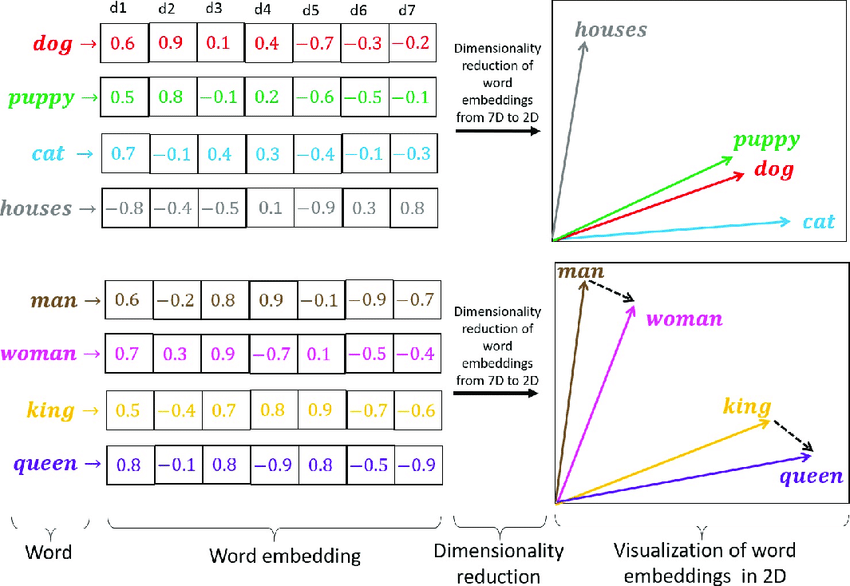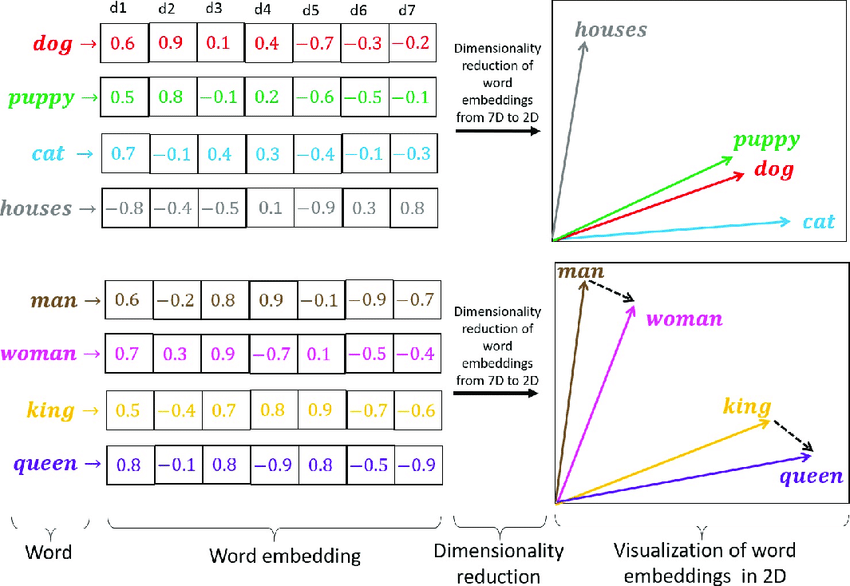

As a preliminary step for the embedding model, it is required to initialize the embedding weights with random values (this is called warmup) so it doesn't start cold (warming up the model help to find a solution faster and avoid valleys where the model could stuck).

Using `torch` `Embedding` layer is a fancy representation of one-hot encoder and matrix multiplication in a fully connected layer (that is, having a high dimensional one-hot and doing a dimensionality reduction using matrix multiplication). Said this, the way to optimize this layer is by training it using backpropagation (as one optimizes the no-negative matrix decomposition).

>NOTE: For more conceptual understanding on how embeddings works, here is a [video](https://youtu.be/wjZofJX0v4M?t=747&si=PYii_yDpiTVC89ji) that explain it better

In [36]:
input_ids = torch.tensor([2, 3, 5, 1])
vocab_size = 6
output_dim = 3

torch.manual_seed(123)
embedding_layer = torch.nn.Embedding(vocab_size, output_dim)
print(embedding_layer.weight)

Parameter containing:
tensor([[ 0.3374, -0.1778, -0.1690],
        [ 0.9178,  1.5810,  1.3010],
        [ 1.2753, -0.2010, -0.1606],
        [-0.4015,  0.9666, -1.1481],
        [-1.1589,  0.3255, -0.6315],
        [-2.8400, -0.7849, -1.4096]], requires_grad=True)


In [37]:
# This is basically a lookup operations, the number 3 here corresponds to the fourth 
# row in the embedding_layer.weights
print(embedding_layer(torch.tensor([3])))

tensor([[-0.4015,  0.9666, -1.1481]], grad_fn=<EmbeddingBackward0>)


In [38]:
# Using the input_ids defined above
print(embedding_layer(input_ids))

tensor([[ 1.2753, -0.2010, -0.1606],
        [-0.4015,  0.9666, -1.1481],
        [-2.8400, -0.7849, -1.4096],
        [ 0.9178,  1.5810,  1.3010]], grad_fn=<EmbeddingBackward0>)


## Encoding word positions

LLMs doesn't have a notion of position or order for the tokens within a sequence because of their self-attention mechanism. This means no matter how the embedding layer represent the tokens, the LLM will only consider their vector representation and similarity.

The deterministic position-independent embedding of the token ID is good for reproducibility. Since the self-attention mechanism of the LLM is position-agnostic, it is helpful to inject additional position information into the LLM.

In [39]:
vocab_size = 50_257
output_dim = 256
token_embedding_layer = torch.nn.Embedding(vocab_size, output_dim)

max_length = 4
dataloader = create_dataloader_v1(raw_text, batch_size=8, max_length=max_length, 
                                  stride=max_length, shuffle=False)
data_iter = iter(dataloader)
inputs, targets = next(data_iter)
print("Token IDs:\n", inputs)
print("\nInputs shape:\n", inputs.shape)

Token IDs:
 tensor([[   40,   367,  2885,  1464],
        [ 1807,  3619,   402,   271],
        [10899,  2138,   257,  7026],
        [15632,   438,  2016,   257],
        [  922,  5891,  1576,   438],
        [  568,   340,   373,   645],
        [ 1049,  5975,   284,   502],
        [  284,  3285,   326,    11]])

Inputs shape:
 torch.Size([8, 4])


In [40]:
token_embeddings = token_embedding_layer(inputs)
print(token_embeddings.shape)

torch.Size([8, 4, 256])


In [41]:
context_length = max_length
pos_embedding_layer = torch.nn.Embedding(context_length, output_dim)
# This will create a placeholder having an array with consecutive numbers.
pos_embeddings = pos_embedding_layer(torch.arange(context_length))
print(pos_embeddings.shape)

torch.Size([4, 256])


In [42]:
# At this step, the input embeddings is the sum of the token embeddings 
# (generated by the embedding layer) and a positional embeddings 
# (that represent the order of each embedding)
input_embeddings = token_embeddings + pos_embeddings
print(input_embeddings.shape)

torch.Size([8, 4, 256])


# Self-attention mechanism

The next step is to create an attention mechanism that provides to the LLM relevant context to each word.

For example, having the phrases:

- American shrew mole
- One mole of carbon dioxide
- Take a biopsy of the mole

In these three phrases **mole** mean different things, but the LLM doesn't know what you refer to since their tokens are exactly the same.

Therefore, the LLM should be capable of extracting the context to each sentence and build the meaning of each **mole** based on their surrounding context.

Before transformers where popular, Recurrent Neural Networks (RNNs) were the way to perform translations becuase of their capability to extract information from sequence, using a similar architecture of encoder-decoder. However, their predictions relies only in the very next word, without considering previous words.

Researchers developed the Bahdanau attention mechanism for RNNs in 2014, allowing the decoder ti sekectuveky access dufferent parts of the input sequence at each decoding step.

This motivates other researches to create self-attention mechanisms without the usage of deep neural networks.

> NOTE: This [video](https://youtu.be/eMlx5fFNoYc?si=SJOY9jKveNWiMTfb) explaing better than I how attention mechanism works.

## Attending to different parts of the input with self-attention

The **"self"** refers to the mechanism's ability to compute attention weights by relating different positions within a single input sequence (like said before, the LLM should build the meaning of all words in a sentence).

In the following example, the intention is to achieve the following:

1. Compute attention scores
2. Compute attention weights (or `w`)
3. Compute context vector

> **What is query, key and value?**
> 
> The concept is borrowed from infromation retrieval and databases.
>
> Where ***query*** is the search term, represented here as the current item;
> 
> ***key*** is used for indexing and searching, in attention mechanisms each word in a sentence has an associated key; and
>
> ***value*** is similar to the value in a key-value pair in a database, represented as the actual content or presentation of the input items.

In [43]:
import torch
inputs = torch.tensor(
    [[0.43, 0.15, 0.89], # Your
     [0.55, 0.87, 0.66], # journey
     [0.57, 0.85, 0.64], # starts
     [0.22, 0.58, 0.33], # with
     [0.77, 0.25, 0.10], # one
     [0.05, 0.80, 0.55]] # step
)

In [44]:
# 1. Attention scores

# To calculate attention scores between the query token and each input token, we use the dot product
query = inputs[1]
attn_scores_2 = torch.empty(inputs.shape[0])
for i, x_i in enumerate(inputs):
    attn_scores_2[i] = torch.dot(x_i, query)

print(attn_scores_2)

tensor([0.9544, 1.4950, 1.4754, 0.8434, 0.7070, 1.0865])


In [45]:
# 2. Attention weights

# Now, lets convert the scores into weights by normalizing them.

# Normalization will make all scores to sum up to 1, 
# this is a common practice that's useful for interpretation and training stability.

# Using softmax manage extreme values and offers more favorable gradient properties during training.

# In addition, softmax ensures that all values are positive, 
# making the output interpretable as probabilities

attn_weights_2 = torch.softmax(attn_scores_2, dim=0)
print("Attention weights: ", attn_weights_2)

Attention weights:  tensor([0.1385, 0.2379, 0.2333, 0.1240, 0.1082, 0.1581])


In [46]:
# 3. Context Vector

# Last step is calculate the context vector. This vector is a weighted sum of all input vectors.

query = inputs[i]
context_vec_2 = torch.zeros(query.shape)
for i, x_i in enumerate(inputs):
    context_vec_2 += attn_weights_2[i]*x_i

print(context_vec_2)

tensor([0.4419, 0.6515, 0.5683])


In [47]:
# Generalizing the previous three steps into a single one to compute context vectors to all inputs

# 1. Attention scores
attn_scores = inputs @ inputs.T # <- the @ is the same as having two for loops 
                                #    multiplying the two dimension input.

print(attn_scores)

tensor([[0.9995, 0.9544, 0.9422, 0.4753, 0.4576, 0.6310],
        [0.9544, 1.4950, 1.4754, 0.8434, 0.7070, 1.0865],
        [0.9422, 1.4754, 1.4570, 0.8296, 0.7154, 1.0605],
        [0.4753, 0.8434, 0.8296, 0.4937, 0.3474, 0.6565],
        [0.4576, 0.7070, 0.7154, 0.3474, 0.6654, 0.2935],
        [0.6310, 1.0865, 1.0605, 0.6565, 0.2935, 0.9450]])


In [48]:
# 2. Attention weights

attn_weights = torch.softmax(attn_scores, dim=-1)
print(attn_weights)

tensor([[0.2098, 0.2006, 0.1981, 0.1242, 0.1220, 0.1452],
        [0.1385, 0.2379, 0.2333, 0.1240, 0.1082, 0.1581],
        [0.1390, 0.2369, 0.2326, 0.1242, 0.1108, 0.1565],
        [0.1435, 0.2074, 0.2046, 0.1462, 0.1263, 0.1720],
        [0.1526, 0.1958, 0.1975, 0.1367, 0.1879, 0.1295],
        [0.1385, 0.2184, 0.2128, 0.1420, 0.0988, 0.1896]])


In [49]:
# 3. Context vectors

all_context_vecs = attn_weights @ inputs
print(all_context_vecs)

tensor([[0.4421, 0.5931, 0.5790],
        [0.4419, 0.6515, 0.5683],
        [0.4431, 0.6496, 0.5671],
        [0.4304, 0.6298, 0.5510],
        [0.4671, 0.5910, 0.5266],
        [0.4177, 0.6503, 0.5645]])


## Self-attention mechanism with trainable weights

The next step is adding trainable weights that are updated during model training, so the model can learn to produce good context vectors.

The new self-attention mechanism will use three trainable weights matrices, $W_q$, $W_k$, $W_v$. These matrices are used to project the embedded input tokens into query, key, and value vectors.

The first word would only has key and value vectors, then the second word would has query, key and value vectors (the query vector is computed via matrix multiplication between the input and the weight matrix $W_q$).

In [50]:
x_2 = inputs[1]
d_in = inputs.shape[1]
d_out = 2

torch.manual_seed(123)
W_query = torch.nn.Parameter(torch.rand(d_in, d_out), requires_grad=False)
W_key = torch.nn.Parameter(torch.rand(d_in, d_out), requires_grad=False)
W_value = torch.nn.Parameter(torch.rand(d_in, d_out), requires_grad=False)

In [51]:
# Query, key and values computation

query_2 = x_2 @ W_query
key_2 = x_2 @ W_key
value_2 = x_2 @ W_value

print(query_2)

tensor([0.4306, 1.4551])


In [52]:
# Keys and values vectors

keys = inputs @ W_key
values = inputs @ W_value
print("keys.shape: ", keys.shape)
print("values.shape: ", values.shape)

keys.shape:  torch.Size([6, 2])
values.shape:  torch.Size([6, 2])


In [53]:
# Attention scores

keys_2 = keys[1]
attn_scores_22 = query_2.dot(keys_2)
print(attn_scores_22)

tensor(1.8524)


In [54]:
# Attention scores generalization

attn_scores_2 = query_2 @ keys.T
print(attn_scores_2)

tensor([1.2705, 1.8524, 1.8111, 1.0795, 0.5577, 1.5440])


In [55]:
# Attention scores normalization (attention weights)
# At this step, a scaling is performed over the attention scores. This is to avoid small gradients that
# can turn softmax function into a step function, slowing down learning.

d_k = keys.shape[-1]
attn_weights_2 = torch.softmax(attn_scores_2 / d_k**0.5, dim=-1)
print(attn_weights_2)

tensor([0.1500, 0.2264, 0.2199, 0.1311, 0.0906, 0.1820])


In [56]:
context_vec_2 = attn_weights_2 @ values
print(context_vec_2)

tensor([0.3061, 0.8210])


In [57]:
# Compact self-attention class
import torch.nn as nn

class SelfAttention_v1(nn.Module):

    def __init__(self, d_in, d_out):
        super().__init__()
        self.W_query = nn.Parameter(torch.rand(d_in, d_out))
        self.W_key = nn.Parameter(torch.rand(d_in, d_out))
        self.W_value = nn.Parameter(torch.rand(d_in, d_out))

    def forward(self, x):
        keys = x @ self.W_key
        queries = x @ self.W_query
        values = x @ self.W_value
        attn_scores = queries @ keys.T # omega
        attn_weights = torch.softmax(
            attn_scores / keys.shape[-1]**0.5, dim=-1
        )
        context_vec = attn_weights @ values
        return context_vec

In [58]:
torch.manual_seed(123)
sa_v1 = SelfAttention_v1(d_in, d_out)
print(sa_v1(inputs))

tensor([[0.2996, 0.8053],
        [0.3061, 0.8210],
        [0.3058, 0.8203],
        [0.2948, 0.7939],
        [0.2927, 0.7891],
        [0.2990, 0.8040]], grad_fn=<MmBackward0>)


In [59]:
# To improve performance and be able to optimice weights, we replace nn.Parameter to nn.Linear
# This layer calculates dot product if bias is removed

class SelfAttention_v2(nn.Module):

    def __init__(self, d_in, d_out, qkv_bias=False):
        super().__init__()
        self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_key = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)

    def forward(self, x):
        keys = self.W_key(x)
        queries = self.W_query(x)
        values = self.W_value(x)
        attn_scores = queries @ keys.T # omega
        attn_weights = torch.softmax(
            attn_scores / keys.shape[-1]**0.5, dim=-1
        )
        context_vec = attn_weights @ values
        return context_vec

In [60]:
torch.manual_seed(123)
sa_v2 = SelfAttention_v2(d_in, d_out)
print(sa_v2(inputs))

tensor([[-0.5337, -0.1051],
        [-0.5323, -0.1080],
        [-0.5323, -0.1079],
        [-0.5297, -0.1076],
        [-0.5311, -0.1066],
        [-0.5299, -0.1081]], grad_fn=<MmBackward0>)


In [61]:
# The author suggests to validate whether two methods are numerically correct. Therefore, produce
# the same result, since the SelfAttention_v2 uses a linear layer and the SeflAttention_v1 builds
# the weights manually, then we should transfer the weights from one to another.

# Entering into details, the way to do that is by extracting the weights from each Linear layer and 
# transpose them to then make a copy into an instance of SelfAttention_v1.

# By doing this, we can confirm that the output is the same, so the processes are numerically correct.

with torch.no_grad(): # <- nn.Layer uses gradiant, to copy weights we need to tell torch not to copy the grads
    sa_v1.W_query.copy_(sa_v2.W_query.weight.T.data)
    sa_v1.W_value.copy_(sa_v2.W_value.weight.T.data)
    sa_v1.W_key.copy_(sa_v2.W_key.weight.T.data)

print(sa_v1(inputs))

tensor([[-0.5337, -0.1051],
        [-0.5323, -0.1080],
        [-0.5323, -0.1079],
        [-0.5297, -0.1076],
        [-0.5311, -0.1066],
        [-0.5299, -0.1081]], grad_fn=<MmBackward0>)


## Causal attention

When training LLM, the desired outcome will require to consider only token that appear prior to the current position.

Causal attention is also know as *masked attention*, it restricts a model to only consider previous and current inputs in a sequence when processing any given token when computing attention socres.

The idea is to mask the attention weights above the diagonal and normalize the nonmasked attention weights such that the attention weights sum to 1 in each row.

In [62]:
# Reusing the SelfAttention mechanism v2, calculate the attention scores of the input
queries = sa_v2.W_query(inputs)
keys = sa_v2.W_key(inputs)
attn_scores = queries @ keys.T
attn_weights = torch.softmax(attn_scores / keys.shape[-1]**0.5, dim=-1)
print(attn_weights)

tensor([[0.1717, 0.1762, 0.1761, 0.1555, 0.1627, 0.1579],
        [0.1636, 0.1749, 0.1746, 0.1612, 0.1605, 0.1652],
        [0.1637, 0.1749, 0.1746, 0.1611, 0.1606, 0.1651],
        [0.1636, 0.1704, 0.1702, 0.1652, 0.1632, 0.1674],
        [0.1667, 0.1722, 0.1721, 0.1618, 0.1633, 0.1639],
        [0.1624, 0.1709, 0.1706, 0.1654, 0.1625, 0.1682]],
       grad_fn=<SoftmaxBackward0>)


In [63]:
# Then create the hidding mask
context_length = attn_scores.shape[0]
mask_simple = torch.tril(torch.ones(context_length, context_length))
print(mask_simple)

tensor([[1., 0., 0., 0., 0., 0.],
        [1., 1., 0., 0., 0., 0.],
        [1., 1., 1., 0., 0., 0.],
        [1., 1., 1., 1., 0., 0.],
        [1., 1., 1., 1., 1., 0.],
        [1., 1., 1., 1., 1., 1.]])


In [64]:
# Apply the hidding mask to the actual attention weights to hide the weights above the diagonal
masked_simple = attn_weights*mask_simple
print(masked_simple)

tensor([[0.1717, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.1636, 0.1749, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.1637, 0.1749, 0.1746, 0.0000, 0.0000, 0.0000],
        [0.1636, 0.1704, 0.1702, 0.1652, 0.0000, 0.0000],
        [0.1667, 0.1722, 0.1721, 0.1618, 0.1633, 0.0000],
        [0.1624, 0.1709, 0.1706, 0.1654, 0.1625, 0.1682]],
       grad_fn=<MulBackward0>)


In [65]:
# Renormalize the attention weights to sum up to 1
row_sums = masked_simple.sum(dim=-1, keepdim=True)
masked_simple_norm = masked_simple / row_sums
print(masked_simple_norm)

tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.4833, 0.5167, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.3190, 0.3408, 0.3402, 0.0000, 0.0000, 0.0000],
        [0.2445, 0.2545, 0.2542, 0.2468, 0.0000, 0.0000],
        [0.1994, 0.2060, 0.2058, 0.1935, 0.1953, 0.0000],
        [0.1624, 0.1709, 0.1706, 0.1654, 0.1625, 0.1682]],
       grad_fn=<DivBackward0>)


> #### Information leakage
>
> It might appear that the information for future tokens (the ones that are hidden) could still influence the current token becuase their values are part of the softmax calculation.
>
> However, when renormalizing the attention weights after masking, weights are recalculated by softmax. The above diagonal doesn't contribute to the softmax score becuase its values are nullified.
>
> Masking and renormalizing the distribution of the attention weights is as if it was calculated only among the unmasked position to begin with.

An efficient way to obtain the masked attention weight matrix, and the one that will be implemented in the next cells, is as follow:

1. Attention scores (unnormalized)
   - Mask with $-\infty$ above diagonal
2. Masked attention scores (unnormalized)
   - Apply softmax
3. Masked attention weights (normalized)

#### Why using $-\infty$ to mask instead of zero?

Before answer the question, let's review the softmax formula

$$
softmax(z_i) = \frac{e^{z_i}}{\sum_je^{z_j}}
$$

When $z_j=0$ then $e^{z_j}=1$ becuase any number powered to zero will be 1. Therefore, all masked values by 0 will contribute to the softmax score, to avoid any contribution by the above diagonal (i.e. the masked values) $z_j$ must be $-\infty$.

To prove that, we can plot $e^x$ where $x \in [-3,3]$, being visible that $e$ decrease, tending to zero (also, if you calculate $\lim_{x \to -\infty}e^x$ you will get that $e^x=0$. Meaning that all values masked with $-\infty$ will not contribute to the softmax score).

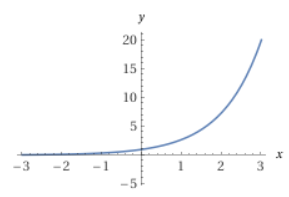

In [66]:
mask = torch.triu(torch.ones(context_length, context_length), diagonal=1)
masked = attn_scores.masked_fill(mask.bool(), -torch.inf)
print(masked)

tensor([[0.3111,   -inf,   -inf,   -inf,   -inf,   -inf],
        [0.1655, 0.2602,   -inf,   -inf,   -inf,   -inf],
        [0.1667, 0.2602, 0.2577,   -inf,   -inf,   -inf],
        [0.0510, 0.1080, 0.1064, 0.0643,   -inf,   -inf],
        [0.1415, 0.1875, 0.1863, 0.0987, 0.1121,   -inf],
        [0.0476, 0.1192, 0.1171, 0.0731, 0.0477, 0.0966]],
       grad_fn=<MaskedFillBackward0>)


In [67]:
# The output values sum to 1 in each row
attn_weights = torch.softmax(masked / keys.shape[-1]**0.5, dim=1)
print(attn_weights)

tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.4833, 0.5167, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.3190, 0.3408, 0.3402, 0.0000, 0.0000, 0.0000],
        [0.2445, 0.2545, 0.2542, 0.2468, 0.0000, 0.0000],
        [0.1994, 0.2060, 0.2058, 0.1935, 0.1953, 0.0000],
        [0.1624, 0.1709, 0.1706, 0.1654, 0.1625, 0.1682]],
       grad_fn=<SoftmaxBackward0>)


## Dropout

During the LLM training it's necessary to use a deep learning technique called dropout, it consists on randomly selecting hiddel layer units and ignored them.

This method helps prevent overfitting by ensuring that a model does not become overly reliant on any specific set of hidden layer units.

This technique is used **ONLY** during training and is disabled afterward.

The dropout can ocurr either after calculating the attention weights or after applying the attention weights to the value vectors. In this example, the dropout will take place after computing the attention weights.

The dropout rate is goint to be of 50%, but when training the real model, the dropout rate will lower to 0.1 or 0.2.

When applying dropout with a rate of 50%, half of the elements in the matrix are randomly set to zero. To compensate for the reduction, active elements scaled up their values by a factor of $1/0.5 = 2$. This scaling is crucial to maintain the overall balance of the attention weights.

In [68]:
torch.manual_seed(123)
dropout = torch.nn.Dropout(0.5)
example = torch.ones(6, 6)
print(dropout(example))

tensor([[2., 2., 2., 2., 2., 2.],
        [0., 2., 0., 0., 0., 0.],
        [0., 0., 2., 0., 2., 0.],
        [2., 2., 0., 0., 0., 2.],
        [2., 0., 0., 0., 0., 2.],
        [0., 2., 0., 0., 0., 0.]])


In [69]:
torch.manual_seed(123)
print(dropout(attn_weights))

tensor([[2.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 1.0335, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.6804, 0.0000, 0.0000, 0.0000],
        [0.4889, 0.5090, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.3988, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.3418, 0.0000, 0.0000, 0.0000, 0.0000]],
       grad_fn=<MulBackward0>)


In [70]:
# Causal attention mechanism implementation
class CausalAttention(nn.Module):
    def __init__(self, d_in, d_out, context_length, dropout, qkv_bias=False):
        super().__init__()
        self.d_out = d_out
        self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_key = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)
        
        self.dropout = nn.Dropout(dropout) # Adding dropout layer
        self.register_buffer(
            'mask',
            torch.triu(torch.ones(context_length, context_length), diagonal=1)
        ) # Ensures this tensor is allocated in the same device as the rest of the LLM

    def forward(self, x):
        b, num_tokens, d_in = x.shape # Keeps batch dimension at the first position (0)
        keys = self.W_key(x)
        queries = self.W_query(x)
        values = self.W_value(x)

        attn_scores = queries @ keys.transpose(1,2)
        # The masked_fill operation occurrs in memory
        # this happens to all operations with an underscore
        attn_scores.masked_fill_(self.mask.bool()[:num_tokens, :num_tokens], -torch.inf)

        attn_weights = torch.softmax(attn_scores / keys.shape[-1]**0.5, dim=-1)
        attn_weights = self.dropout(attn_weights)

        context_vec = attn_weights @ values
        return context_vec

In [71]:
batch = torch.stack((inputs, inputs), dim=0)
print(batch.shape)

torch.Size([2, 6, 3])


In [72]:
torch.manual_seed(123)
context_length = batch.shape[1]
ca = CausalAttention(d_in, d_out, context_length, 0.0)
context_vecs = ca(batch)
print("context_vecs.shape:", context_vecs.shape)

context_vecs.shape: torch.Size([2, 6, 2])


## Multi-head attention

The final step for attention mechanisms is to extend the causal attention class over multiple heads. This is called *multi-head attention*.

The term *"multi-head"* refers to dividing the attention mechanism into multiple *"heads"*, each operating independently.

To tackle this expansing, the first steps is intuitively build a multi-head attention module by stacking multiple CausalAttention modules.

The wrapper consists on having multiple instance of the CausalAttention class and then combine their outputs.

However, the `MultiHeadAttentionWrapper` works sequentially becuase of the `for` loop, also being computational inneficient. One way to be more efficient is by computing the output for all attention heads simultaneously via matrix multiplication.

In [73]:
class MultiHeadAttentionWrapper(nn.Module):
    def __init__(self, d_in, d_out, context_length, dropout, num_heads, qkv_bias=False):
        super().__init__()
        self.heads = nn.ModuleList(
            [CausalAttention(
                d_in, d_out, context_length, dropout, qkv_bias
             ) 
             for _ in range(num_heads)]
        )

    def forward(self, x):
        return torch.cat([head(x) for head in self.heads], dim=-1)

In [74]:
torch.manual_seed(123)
context_length = batch.shape[1] # Number of tokens
d_in, d_out = 3, 2
mha = MultiHeadAttentionWrapper(
    d_in, d_out, context_length, 0.0, num_heads=2
)
context_vecs = mha(batch)

print(context_vecs)
print("context_vecs.shape:", context_vecs.shape)

tensor([[[-0.4519,  0.2216,  0.4772,  0.1063],
         [-0.5874,  0.0058,  0.5891,  0.3257],
         [-0.6300, -0.0632,  0.6202,  0.3860],
         [-0.5675, -0.0843,  0.5478,  0.3589],
         [-0.5526, -0.0981,  0.5321,  0.3428],
         [-0.5299, -0.1081,  0.5077,  0.3493]],

        [[-0.4519,  0.2216,  0.4772,  0.1063],
         [-0.5874,  0.0058,  0.5891,  0.3257],
         [-0.6300, -0.0632,  0.6202,  0.3860],
         [-0.5675, -0.0843,  0.5478,  0.3589],
         [-0.5526, -0.0981,  0.5321,  0.3428],
         [-0.5299, -0.1081,  0.5077,  0.3493]]], grad_fn=<CatBackward0>)
context_vecs.shape: torch.Size([2, 6, 4])


In [75]:
# The author suggets the following exercise. Changing the input arguments for the 
# MultiHeadAttentionWrapper, so the output context vectos are two-dimensional instead 
# of four dimensional

# To achieve the desire result, I change the d_out variable since the last dimension (2) is the result
# of multiplying d_out by num_heads.

# Said this, one can get the same result by modifying num_heads to 1

torch.manual_seed(123)
context_length = batch.shape[1] # Number of tokens
d_in, d_out = 3, 1
mha = MultiHeadAttentionWrapper(
    d_in, d_out, context_length, 0.0, num_heads=2
)
context_vecs = mha(batch)

print("context_vecs.shape:", context_vecs.shape)

context_vecs.shape: torch.Size([2, 6, 2])


In [76]:
# Causal attention mechanism implementation based on matrix multiplication

class MultiHeadAttention(nn.Module):
    def __init__(self, d_in, d_out, context_length, dropout, num_heads, qkv_bias=False):
        super().__init__()
        assert (d_out % num_heads == 0), "d_out must be divisible by num_heads"
        self.d_out = d_out
        self.num_heads = num_heads
        self.head_dim = d_out // num_heads # Reduces projection dim to match the desired output dim
        
        self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_key = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)
        
        self.out_proj = nn.Linear(d_out, d_out) # Used to combine heads output
        self.dropout = nn.Dropout(dropout)
        self.register_buffer(
            'mask',
            torch.triu(torch.ones(context_length, context_length), diagonal=1)
        )

    def forward(self, x):
        b, num_tokens, d_in = x.shape
        
        keys = self.W_key(x) # Tensor shape (b, num_tokens, d_out)
        queries = self.W_query(x) # Tensor shape (b, num_tokens, d_out)
        values = self.W_value(x) # Tensor shape (b, num_tokens, d_out)

        # Implicitly split the matrix by adding a num_head dimension
        keys = keys.contiguous().view(b, num_tokens, self.num_heads, self.head_dim)
        values = values.contiguous().view(b, num_tokens, self.num_heads, self.head_dim)
        queries = queries.contiguous().view(b, num_tokens, self.num_heads, self.head_dim)

        # Transpose from shape (b, num_tokens, num_heads, head_dim) to
        # (b, num_heads, num_tokens, head_dim)
        keys = keys.transpose(1, 2)
        queries = queries.transpose(1, 2)
        values = values.transpose(1, 2)

        attn_scores = queries @ keys.transpose(2, 3) # Dot product for each head
        # Mask truncated to the number of tokens
        mask = self.mask[:num_tokens, :num_tokens].unsqueeze(0).unsqueeze(0)
        # Uses the mask to fill attention scores
        attn_scores.masked_fill_(mask.bool(), -torch.inf)

        attn_weights = torch.softmax(attn_scores / keys.shape[-1]**0.5, dim=-1)
        attn_weights = self.dropout(attn_weights)

        # Tensor shape: (b, num_tokens, n_heads, head_dim)
        # Combine heads, where self.d_out = self.num_heads*self.head_dim
        context_vec = (attn_weights @ values).transpose(1, 2)
        context_vec = context_vec.contiguous().view(b, num_tokens, self.d_out)
        context_vec = self.out_proj(context_vec) # Adds an optional linear projection
        return context_vec

In [77]:
torch.manual_seed(123)
batch_size, context_length, d_in = batch.shape
d_out = 2
mha = MultiHeadAttention(d_in, d_out, context_length, 0.0, num_heads=2)
context_vecs = mha(batch)
print(context_vecs)
print("context_vecs.shape:", context_vecs.shape)

tensor([[[0.3190, 0.4858],
         [0.2943, 0.3897],
         [0.2856, 0.3593],
         [0.2693, 0.3873],
         [0.2639, 0.3928],
         [0.2575, 0.4028]],

        [[0.3190, 0.4858],
         [0.2943, 0.3897],
         [0.2856, 0.3593],
         [0.2693, 0.3873],
         [0.2639, 0.3928],
         [0.2575, 0.4028]]], grad_fn=<ViewBackward0>)
context_vecs.shape: torch.Size([2, 6, 2])


In [78]:
# The author propose the following exercise. Initialize a multi-head attention module 
# that has the same number of attention heads as the smallest GPT-2 model 
# (12 attention heads, output embedding sizes of 768 dimensions, and context length of 1,024 tokens)

d_in = 768
d_out = 768
num_heads = 12
context_length = 1_024
mha = MultiHeadAttention(d_in, d_out, context_length, 0.0, num_heads=num_heads)

# Text Generation

## Coding an LLM architecture

Until this point, most of the LLM architecture is already coded and the complexity of the architecture relies on repeate most of the components.

During the following implementation, we will be talking about parameters that are the trainable weights of the model, for example, a neural network of 2,048 x 2,048-dimensional matrix of weights size will represent 4,194,304 parameters.

To start, let's define a GPT (***G****enerative* ***P****retrained* ***T****ransformer*) with a 124M trainable parameters, with the following variable definition:

- `vocab_size`: Vocabulary size of 50,257 words, as used by the [BPE tokenizer](#Byte-Pairing-Encoding-(BPE))
- `context_length`: Maximum number of input tokens the model can handle via the [positional embeddings](#Encoding-word-positions)
- `emb_dim`: Embedding size, transforming each token into a 768-dimensional vector
- `n_heads`: Number of attention heads in the multi-head [attention mechanism](#Multi-head-attention)
- `n_layers`: Number of transformer blocks in the model
- `drop_rate`: Intendity of the [dropout mechanism](#Dropout) (0.1 implies a 10% random drop out of hidden  units)
- `qkv_bias`: Whether to include a bias vector in the `Linear` layers of the multi-head attention for query, key and value computations.

In [79]:
GPT_CONFIG_124M = {
    "vocab_size": 50_257,
    "context_length": 1_024,
    "emb_dim": 768,
    "n_heads": 12,
    "n_layers": 12,
    "drop_rate": 0.1,
    "qkv_bias": False
}

In [80]:
import torch
import torch.nn as nn

class DummyGPTModel(nn.Module):

    def __init__(self, cfg):
        super().__init__()
        self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
        self.pos_emb = nn.Embedding(cfg['context_length'], cfg['emb_dim'])
        self.drop_emb = nn.Dropout(cfg['drop_rate'])
        # Uses a placeholder for TransformerBlock
        self.trf_blocks = nn.Sequential(*[DummyTransformerBlock(cfg) for _ in range(cfg['n_layers'])])
        # Uses a placeholder for LayerNorm
        self.final_norm = DummyLayerNorm(cfg['emb_dim'])
        self.out_head = nn.Linear(cfg['emb_dim'], cfg['vocab_size'], bias=False)

    def forward(self, in_idx):
        """
        Describes the data flow through the model: computes token and positional embeddings
        for the input indices, applies dropout, processes the data through the transformer
        blocks, applies normalization, and finally produces logits with the linear output layer
        """
        batch_size, seq_len = in_idx.shape
        tok_embeds = self.tok_emb(in_idx)
        pos_embeds = self.pos_emb(
            torch.arange(seq_len, device=in_idx.device)
        )
        x = tok_embeds + pos_embeds
        x = self.drop_emb(x)
        x = self.trf_blocks(x)
        x = self.final_norm(x)
        logits = self.out_head(x)
        return logits

# A simple placeholder class that will be replaced by a real TransformerBlock layer
class DummyTransformerBlock(nn.Module):
    def __init__(self, cfg):
        super().__init__()

    # This block does nothing and just returns its input
    def forward(self, x):
        return x

# The paramter here are just to mimic the LayerNorm interface
class DummyLayerNorm(nn.Module):
    def __init__(self, normalized_shape, eps=1e-5):
        super().__init__()

    def forward(self, x):
        return x

In [81]:
import tiktoken

tokenizer = tiktoken.get_encoding("gpt2")
batch = []
txt1 = "Every effort moves you"
txt2 = "Every day holds a"

batch.append(torch.tensor(tokenizer.encode(txt1)))
batch.append(torch.tensor(tokenizer.encode(txt2)))
batch = torch.stack(batch, dim=0)
print(batch)

tensor([[6109, 3626, 6100,  345],
        [6109, 1110, 6622,  257]])


In [82]:
# The ouput has 2 rows corresponding to the two text samples
# Each text sample consists of 4 tokens
# Each tplen is a 50,257-dimensional vector, matching the size of the tokenizer's vocabulary
torch.manual_seed(123)
model = DummyGPTModel(GPT_CONFIG_124M)
logits = model(batch)
print("Output shape:", logits.shape)
print(logits) # <- Logits is the common name refering to the model ouputs

Output shape: torch.Size([2, 4, 50257])
tensor([[[-0.9289,  0.2748, -0.7557,  ..., -1.6070,  0.2702, -0.5888],
         [-0.4476,  0.1726,  0.5354,  ..., -0.3932,  1.5285,  0.8557],
         [ 0.5680,  1.6053, -0.2155,  ...,  1.1624,  0.1380,  0.7425],
         [ 0.0447,  2.4787, -0.8843,  ...,  1.3219, -0.0864, -0.5856]],

        [[-1.5474, -0.0542, -1.0571,  ..., -1.8061, -0.4494, -0.6747],
         [-0.8422,  0.8243, -0.1098,  ..., -0.1434,  0.2079,  1.2046],
         [ 0.1355,  1.1858, -0.1453,  ...,  0.0869, -0.1590,  0.1552],
         [ 0.1666, -0.8138,  0.2307,  ...,  2.5035, -0.3055, -0.3083]]],
       grad_fn=<UnsafeViewBackward0>)


## Normalizing activations with layer normalization

Training deep neural networks with many layers can sometimes prove challenging due to problems like vanishing or exploding gradients. Leading to unstable training dynamic and make it difficult for the network to effectively adjust its weights, which means the learning process struggles to find a set of parameters that minimizes the loss function.

A solution to improve stability is by implementing a layer normalization. The idea behind layer normalization is to adjust the activations (outputs) of a neural network layer to have a mean of 0 and a variance of 1 (a.k.a. unit variance).

> In GPT-2 and modern transformer architectyres, layer normalization is typically applied before and after the multi-head attention module, and before the final output layer.

### Vanishing

**Problema**: During backpropagation, gradients values become extremely small as their propagate backwards to the initial layers of the network. Causing the weights in the first layers to not be updated.

**Causes**: 
- Activation functions like sigmoide and hyperbolic tangent, whose derivatives take values less than 1. By multiplying repeatedly during backpropagation, the gradients decrease exponentially.

- Deep networks, where gradients must propagate through a lot of layers.

**Consequences**: 
- First layers learn almost nothing, while last layers keeps all training.
  
- The model may get stuck at a bad minimum local or no convergence.

**Most common solutions**:
- Use activation functions like ReLU that avoids small gradients for positive values.

- Use architectures designed to mitigates this problem like LSTMs or GRUs on recurrent networks.

- Proper weights initialization (He initialization or Xavier initialization)

- Use normalization layers (Batch Normalization)

### Exploding gradients

**Problem**: Gradients become extreamlly big during backpropagation, producing excessive weight updates.

**Causes**:
- Intialized weights with big values.

- Deep networks where grdients multiply repeatedly by weight matrices with high norms.

**Consequences**:
- Numeric instability: Weights take inifity values or NaN

- Abrupt overfitting or divergence

**Most common solutions**:
- Gradient Clipping: Artificially limit the gradient's maximum valuen during backpropagation.

- Use of L2 regularization to penalize big weights.

- Carefully weight initialization

- Architectres with residual connections (ResNets), that facilitate the flow of gradients.

In [83]:
# For this implementation, the Linear layer is followed by a nonlinear activation functions ReLU that thresholds negative inputs to 0,
# ensuring layer output only contains positive values.
torch.manual_seed(123)
batch_example = torch.randn(2, 5)
layer = nn.Sequential(nn.Linear(5, 6), nn.ReLU())
out = layer(batch_example)
print(out)

tensor([[0.2260, 0.3470, 0.0000, 0.2216, 0.0000, 0.0000],
        [0.2133, 0.2394, 0.0000, 0.5198, 0.3297, 0.0000]],
       grad_fn=<ReluBackward0>)


### Layer Normalization

As mentioned before, the main idea normalization is to adjust activations (outputs) of a neural network layer to have a mean of 0 and a variance of 1, also known as unit variance.

Analyzing the previous random generated output, the mean and variance of the two sequences have not a unit variance.

To achieve this result, the operation consists of subtracting the mean and dividing by the square root of the variance (or standard deviation)

$$
normalization = \frac{x-\overline{x}}{\sigma};
$$
$$
Where
$$
$$
\sigma = \sqrt{var}
$$

In [84]:
mean = out.mean(dim=-1, keepdim=True)
var = out.var(dim=-1, keepdim=True)
print("Mean:\n", mean)
print("Variance:\n", var)

Mean:
 tensor([[0.1324],
        [0.2170]], grad_fn=<MeanBackward1>)
Variance:
 tensor([[0.0231],
        [0.0398]], grad_fn=<VarBackward0>)


In [85]:
# This line disables the scientific notation, so the output is readable
torch.set_printoptions(sci_mode=False)

out_norm = (out - mean) / torch.sqrt(var)
mean = out_norm.mean(dim=-1, keepdim=True)
var = out_norm.var(dim=-1, keepdim=True)
print("Normalized layer outputs:\n", out_norm)
print("Mean:\n", mean)
print("Variance:\n", var)

Normalized layer outputs:
 tensor([[ 0.6159,  1.4126, -0.8719,  0.5872, -0.8719, -0.8719],
        [-0.0189,  0.1121, -1.0876,  1.5173,  0.5647, -1.0876]],
       grad_fn=<DivBackward0>)
Mean:
 tensor([[    0.0000],
        [    0.0000]], grad_fn=<MeanBackward1>)
Variance:
 tensor([[1.0000],
        [1.0000]], grad_fn=<VarBackward0>)


In [86]:
    # Having the previous explanation, it is possible to develope a normalization layer
    class LayerNorm(nn.Module):
        def __init__(self, emb_dim):
            super().__init__()
            self.eps = 1e-5
            # These two parameters are trainable so the LLM will learn an appropiate scaling and shifting
            # that best suit the data it is processing
            self.scale = nn.Parameter(torch.ones(emb_dim))
            self.shift = nn.Parameter(torch.zeros(emb_dim))
    
        def forward(self, x):
            mean = x.mean(dim=-1, keepdim=True)
            var = x.var(dim=-1, keepdim=True, unbiased=False)
            # eps is a small constant to prevent division by zero
            norm_x = (x - mean) / torch.sqrt(var + self.eps)
            return self.scale * norm_x + self.shift

In [87]:
ln = LayerNorm(emb_dim=5)
out_ln = ln(batch_example)
mean = out_ln.mean(dim=-1, keepdim=True)
var = out_ln.var(dim=-1, unbiased=False, keepdim=True)
print("Mean:\n", mean)
print("Variance:\n", var)

Mean:
 tensor([[    -0.0000],
        [     0.0000]], grad_fn=<MeanBackward1>)
Variance:
 tensor([[1.0000],
        [1.0000]], grad_fn=<VarBackward0>)


> **Batch Normalization vs Layer Normalization**
>
> When talking about normalization, both layers performs normalization in the same way, but there is a detail that make them different and their use case.
>
> Batch normalization calculates mean and variance using the current batch, that is `dim 0`. In the current example, changing `out.mean(dim=0)` will be the batch norm and the output will be even different size since the batch norm is calculated for all its features across batches (the output will have the same length as the number of features, in this case, 6).
>
> On the other hand, layer normalization calculates mean and variance using the features, that is `dim 1`. That's why the output is size 2 equal to the number of batches.
>
> Batch normalization is most commonly used in models that has huge batches. While layer normalization is more suitable where batches are smaller.

## Implementing a feed forward network with GELU activations

As part of the GPT implementation, a GELU activation function module is created. In deep learning is most common to use ReLU activation function for its simplicity. However, in LLMs other activation funcitons are employed beyond the traditional ReLU, particularly examples are GELU (*Gaussian error linear unit*) and SwiGLU (*Swish-gated linear unit*).

GELU and SwiGLU are more complex and smooth activation function incorporating Gaussian and sigmoid-gated linear units, offering improved performance for deep learning models, unlike the simpler ReLU

$$
GELU(x)=x \cdot \Phi(x)
$$

> **Why GELU and SwiGLU are better than ReLU**
>
> ReLU has demostrated its efficiency in deep learning models because of its simplicify and capacity to handle negative values. However, GELU and SwiGLU have properties to take into consideration.
>
> First, the $\Phi(x)$ component in the GLUE equation is the standard Gaussian distribution that measures the probability of an unit to be significant. Following this idea, the GLUE activation function preserve units with negative values intead of shutting it down, preserving its values.
>
> The selection of the standard normal distribution function is because the neuron's input follow a normal distribution, particularly after normalization.
> 
> When training models, it's common to use a cheaper approximation to the Gaussian CFD, which was found via curve fitting:
>
> $$
 GELU(x) \approx 0.5 \cdot x \cdot (1+tanh[\sqrt{\frac{2}{\pi}} \cdot (x + 0.044715 \cdot x^3)])
$$
>  
> On the other hand, SwiGLU implements a trainable $\beta$ parameter that models uses to selectively decide the timing to activate routes, similar to LSTM/GRU feedforward networks. It is currently used by LLaMA and PaLM models.

If you want to learn more, here it is a [Medium post](https://medium.com/@shauryagoel/gelu-gaussian-error-linear-unit-4ec59fb2e47c) that explaing the GELU activation function and [the paper to it](https://arxiv.org/pdf/1606.08415v3.pdf). And here is another [Medium post](https://medium.com/@s_boudefel/exploring-swiglu-the-activation-function-powering-modern-llms-9697f88221e7) talking more in deep of SwiGLU.

In [88]:
class GELU(nn.Module):

    def __init__(self):
        super().__init__()

    def forward(self, x):
        return 0.5 * x * (1 + torch.tanh(torch.sqrt(torch.tensor(2.0 / torch.pi)) * (x + 0.044715 * torch.pow(x, 3))))

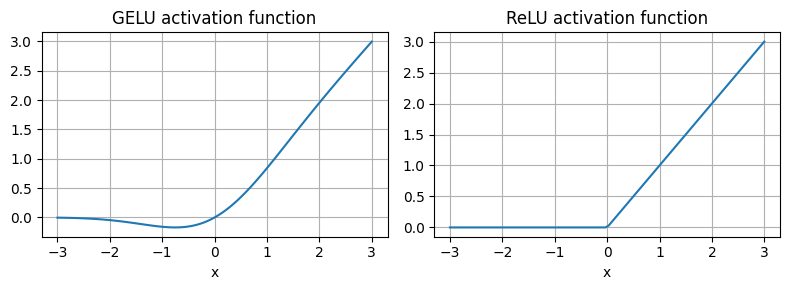

In [89]:
# This is an example of how GELU and ReLU look like and its comparative

import matplotlib.pyplot as plt

gelu, relu = GELU(), nn.ReLU()

x = torch.linspace(-3, 3, 100) # <- 100 samples that range from -3 to 3
y_gelu, y_relu = gelu(x), relu(x)
plt.figure(figsize=(8, 3))
for i, (y, label) in enumerate(zip([y_gelu, y_relu], ["GELU","ReLU"]), 1):
    plt.subplot(1, 2, i)
    plt.plot(x, y)
    plt.title(f"{label} activation function")
    plt.xlabel("x")
    plt.grid(True)

plt.tight_layout()
plt.show()

In [90]:
# Here it is a small network that consists of two Linear layer and the GELU layer in between
# this module is going to be used further in the LLM implementation.

class FeedForward(nn.Module):

    def __init__(self, cfg):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(
                cfg["emb_dim"], 
                4 * cfg["emb_dim"]
            ), 
            nn.GELU(), 
            nn.Linear(
                4 * cfg["emb_dim"],
                cfg["emb_dim"]
            )
        )
        self._init_weights()

    def _init_weights(self):
        # Inicialización tipo GPT-2
        nn.init.normal_(self.layers[0].weight, mean=0.0, std=0.02)
        nn.init.normal_(self.layers[2].weight, mean=0.0, std=0.02)
        nn.init.zeros_(self.layers[0].bias)
        nn.init.zeros_(self.layers[2].bias)

    def forward(self, x):
        return self.layers(x)

In [91]:
# And this is how it looks like when using the GPT 124M parameters configuration.
# In fact the module expands dimensionality at the first Linear layer, it contacts
# back to the orginal dimensionality

ffn = FeedForward(GPT_CONFIG_124M)
x = torch.rand(2, 3, 768)
out = ffn(x)
print(out.shape)

torch.Size([2, 3, 768])


## Adding shortcut connections

As discussed before, there is a problematic in deep neural networks that is the [vanishing gradients](##Normalizing-activations-with-layer-normalization), where gradients become progressively smaller as they propagate backward through the layers. A way to solve vanishing gradients, it's necessary to create shorter paths for the gradient to flow through the network by skipping one or more layers.

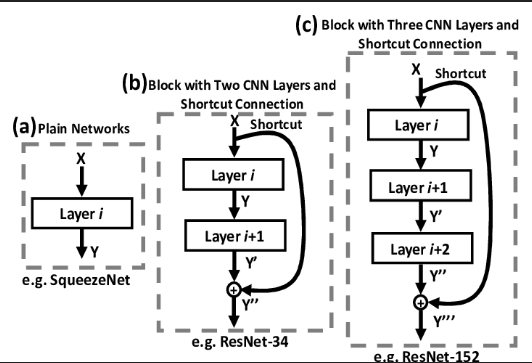

In [92]:
class ExampleDeepNeuralNetwork(nn.Module):
    def __init__(self, layer_sizes, use_shortcut):
        super().__init__()
        self.use_shortcut = use_shortcut
        # Implements 5 layers
        self.layers = nn.ModuleList([
            nn.Sequential(
                nn.Linear(layer_sizes[0], layer_sizes[1]),
                GELU()
            ),
            nn.Sequential(
                nn.Linear(layer_sizes[1], layer_sizes[2]),
                GELU()
            ),
            nn.Sequential(
                nn.Linear(layer_sizes[2], layer_sizes[3]),
                GELU()
            ),
            nn.Sequential(
                nn.Linear(layer_sizes[3], layer_sizes[4]),
                GELU()
            ),
            nn.Sequential(
                nn.Linear(layer_sizes[4], layer_sizes[5]),
                GELU()
            ),
        ])

    def forward(self, x):
        for layer in self.layers:
            layer_output = layer(x) # Compute the output of the current layer
            
            # Check if shorcut can be applied
            if self.use_shortcut and x.shape == layer_output.shape:
                x = x + layer_output
            else:
                x = layer_output
        return x

In [93]:
layer_sizes = [3, 3, 3, 3, 3, 1]
sample_input = torch.tensor([[1., 0., -1.]])
torch.manual_seed(123)
model_without_shortcut = ExampleDeepNeuralNetwork(layer_sizes, use_shortcut=False)

In [94]:
def print_gradients(model, x):
    # Implements a simple backpropagation using the method backward that come pre-built 
    # on the nn.Modules. At the first step, we take the gradients and plot them.
    output = model(x)
    target = torch.tensor([[0.]])

    loss = nn.MSELoss()
    loss = loss(output, target)

    loss.backward()

    for name, params in model.named_parameters():
        if 'weight' in name:
            print(f"{name} has gradient mean of {params.grad.abs().mean().item()}")

In [95]:
# As shown in the print, the gradient becomes smaller and smaller as it is passed through
# the network layers, that is, the vanishing gradient problem.

# Layer 4 first calculates the gradient, and it is passed down through the layer until it reaches
# the first one.
print_gradients(model_without_shortcut, sample_input)

layers.0.0.weight has gradient mean of 0.00020173584925942123
layers.1.0.weight has gradient mean of 0.00012011159560643137
layers.2.0.weight has gradient mean of 0.0007152040489017963
layers.3.0.weight has gradient mean of 0.0013988736318424344
layers.4.0.weight has gradient mean of 0.005049645435065031


In [96]:
# The fourth layer still has a larget gradient than the other layers. However, the gradient
# value stabilizes as is progress toward the first layer.
torch.manual_seed(123)
model_with_shortcut = ExampleDeepNeuralNetwork(
    layer_sizes, use_shortcut=True
)
print_gradients(model_with_shortcut, sample_input)

layers.0.0.weight has gradient mean of 0.22169791162014008
layers.1.0.weight has gradient mean of 0.20694105327129364
layers.2.0.weight has gradient mean of 0.32896995544433594
layers.3.0.weight has gradient mean of 0.2665732204914093
layers.4.0.weight has gradient mean of 1.3258540630340576


## Connecting attention and linear layers in a transformer block

A fundamental building block of GPT and other LLM architectures is the *transformer block*.

It consists of the following sequence:

1. Tokens (shortcut to step 4 output)
2. Layer normalization 1
3. Masked multi-head attention
4. Dropout (shortcut to step 7 output)
    - Here it is a shortcut from step 1, after the dropout output
5. Layer normalization 2
6. Feed forward
    - Linear layer
    - GELU activation
    - Linear layer
7. Dropout
    - Here it is another shortcut from step 4 output
  
It's crucial that the transformer block preserves the shape of the input, enabling effective application across a wide range of sequence-to-sequence tasks. The output encapsulates information from the entire input sequence.

In [97]:
class TransformerBlock(nn.Module):
    
    def __init__(self, cfg):
        super().__init__()
        self.att = MultiHeadAttention(
            d_in=cfg["emb_dim"],
            d_out=cfg["emb_dim"],
            context_length=cfg['context_length'],
            num_heads=cfg['n_heads'],
            dropout=cfg['drop_rate'],
            qkv_bias=cfg['qkv_bias']
        )
        self.ff = FeedForward(cfg)
        self.norm1 = LayerNorm(cfg['emb_dim'])
        self.norm2 = LayerNorm(cfg['emb_dim'])
        self.drop_shortcut = nn.Dropout(cfg['drop_rate'])
        # --- Añade esta función interna ---
        def _init_weights(module):
            if isinstance(module, (nn.Linear, nn.Embedding)):
                torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
                if isinstance(module, nn.Linear) and module.bias is not None:
                    torch.nn.init.zeros_(module.bias)
        # --- Aplica la inicialización al modelo ---
        self.apply(_init_weights)  # Inicializa todos los parámetros recursivamente
    
    def forward(self, x):
        attn_shortcut = x # Shortcut connection for attention block
        x = self.norm1(x)
        x = self.att(x)
        x = attn_shortcut + self.drop_shortcut(x) # Add the original input back

        ff_shortcut = x # Shortcut connection for feed forward block
        x = self.norm2(x)
        x = self.ff(x)
        x = ff_shortcut + self.drop_shortcut(x) # adds the original input back
        return x

In [98]:
torch.manual_seed(123)
x = torch.rand(2, 4, 768)
block = TransformerBlock(GPT_CONFIG_124M)
output = block(x)

print("Input shape:", x.shape)
print("Output shape:", output.shape)

Input shape: torch.Size([2, 4, 768])
Output shape: torch.Size([2, 4, 768])


## Coding the GPT model

Having the `TransformerBlock` and `LayerNorm` classes, a GPT Model can be built by combining these two layers.

The model architectire is somethign like follows:
- Tokenized text
- Token embedding layer
- Positional embedding layer
- Dropout
- Transformer block (x12)
    - Layer Normalization 1 (Input shortcut to first dropout)
    - Masked multi-head attention
    - Dropout (Output shortcut to second dropout)
    - Layer Normalization 2
    - Feed forward
    - Dropout
- Final layer normalization
- Linear output layer

The final transformer block goes through a final layer normalizatino step before reaching the linear output layer. This layer maps the transformer's output to a high-dimensional space to predict the next token in the sequence.

In [99]:
class GPTModel(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.tok_emb = nn.Embedding(cfg['vocab_size'], cfg['emb_dim'])
        self.pos_emb = nn.Embedding(cfg['context_length'], cfg['emb_dim'])
        self.drop_emb = nn.Dropout(cfg['drop_rate'])

        # Repeate the transformer block by the number of layers (in this case, 12)
        self.trf_blocks = nn.Sequential(
            *[TransformerBlock(cfg) for _ in range(cfg['n_layers'])]
        )

        self.final_norm = LayerNorm(cfg['emb_dim'])
        self.out_head = nn.Linear(
            cfg['emb_dim'], cfg['vocab_size'], bias=False
        )
    
        # --- Añade esta función interna ---
        def _init_weights(module):
            if isinstance(module, (nn.Linear, nn.Embedding)):
                torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
                if isinstance(module, nn.Linear) and module.bias is not None:
                    torch.nn.init.zeros_(module.bias)
        
        # --- Aplica la inicialización al modelo ---
        self.apply(_init_weights)  # Inicializa todos los parámetros recursivamente
        self.out_head.weight = self.tok_emb.weight  # Weight tying
    
    def forward(self, in_idx):
        # Input tokenized text
        batch_size, seq_len = in_idx.shape
        # Token embedding layer
        tok_embeds = self.tok_emb(in_idx)

        # Positional embedding layer
        pos_embeds = self.pos_emb(
            torch.arange(seq_len, device=in_idx.device) # Train the model on a CPU or GPU
        )
        x = tok_embeds + pos_embeds
        # Dropout before transformer block
        x = self.drop_emb(x)
        # 12 sequential transformer blocks
        x = self.trf_blocks(x)
        # Final normalization layer
        x = self.final_norm(x)
        # High-dimensional space mapping
        logits = self.out_head(x)
        return logits

In [100]:
torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)

out = model(batch)
print("Input batch:\n", batch)
print("\nOutput shape:", out.shape)
print(out)

Input batch:
 tensor([[6109, 3626, 6100,  345],
        [6109, 1110, 6622,  257]])

Output shape: torch.Size([2, 4, 50257])
tensor([[[-0.8721, -0.3422, -0.2387,  ..., -0.2489,  0.4237, -0.9941],
         [-1.0841,  0.0758, -0.3717,  ..., -0.6503, -0.6429, -1.0605],
         [-0.7891,  0.2204, -0.1465,  ..., -0.1723, -0.3674, -0.6354],
         [-0.5909,  0.6744,  0.0277,  ...,  0.2099, -0.7647, -1.1600]],

        [[-0.8074, -0.3991, -0.7179,  ..., -0.1718, -0.6768, -0.5818],
         [-0.6602,  0.2264,  0.1308,  ..., -0.3449, -0.1299, -1.8680],
         [-0.6323,  0.3656, -0.2030,  ..., -1.0225, -0.2817, -2.1000],
         [-0.0934,  0.6206, -0.0728,  ..., -0.6361, -0.3903, -1.4252]]],
       grad_fn=<UnsafeViewBackward0>)


In [101]:
# Inspecting the number of parameters of the model, there is a discrepancy between
# the actual number of parameters and the desired 124M parameters.

# That is because the original GPT-2 uses a concepted called weight tying. Meaning
# that the original architecture reuses the weights from the token embedding layer 
# in its output layer
total_params = sum(p.numel() for p in model.parameters())
print(f"Total number of parameters: {total_params:,}")

Total number of parameters: 124,412,160


In [102]:
# Input and output layer are very large due to the number of rows for the 50,257 in tokenizer's
# vocabulary
print("Token embedding layer shape:", model.tok_emb.weight.shape)
print("Output layer shape:", model.out_head.weight.shape)

Token embedding layer shape: torch.Size([50257, 768])
Output layer shape: torch.Size([50257, 768])


In [103]:
# By removing the output layer parameter count from the total GPT-2 model count according
# to the weight tying, we get the 124M parameters from the original model.
total_params_gpt2 = (
    total_params - sum(p.numel()
    for p in model.out_head.parameters())
)
print(f"Number of trainable parameters "
     f"considering weight tying: {total_params_gpt2:,}")

Number of trainable parameters considering weight tying: 85,814,784


In [104]:
# The author propose the following excesice
# Calculate and compare the number of parameters that are contained 
# in the feed forward module and those that are contained in the 
# multi-head attention module


# The feed forward module can be accessed from the trf_blocks, then selecting one
# of the 12 blocks and getting the feed forward module and adding all the parameters

ff_num_parameters = sum(p.numel() for p in model.trf_blocks[0].ff.parameters())
print(f"Number of trainable parameters in one feed forward module: {ff_num_parameters:,}")

# To get the multi-head attention module parameters follows the same logic as before.
# Getting one of the transformer blocks and accessing the attention module
att_num_parameters = sum(p.numel() for p in model.trf_blocks[0].att.parameters())
print(f"Number of trainable parameters in one multi-head attention module: {att_num_parameters:,}")

ratio = (ff_num_parameters+att_num_parameters)/total_params
print(f"Ratio of one module parameters, compared with the total params: {ratio:.2%}")

Number of trainable parameters in one feed forward module: 4,722,432
Number of trainable parameters in one multi-head attention module: 2,360,064
Ratio of one module parameters, compared with the total params: 5.69%


In [105]:
# To calculate the memory requirements of the 163M parameters

total_size_bytes = total_params * 4 # <- assuming float32, 4 bytes per parameter
total_size_mb = total_size_bytes / (1024*1024) # <- converts to megabytes
print(f"Total size of the model: {total_size_mb:.2f} MB")

Total size of the model: 474.59 MB


In [106]:
# The author propose the following excesice
# Initialize the GPT-2 medium , large and XL model by modifying only
# the configuration parameters and calculate the total number of
# parameters in each GPT model


# For medium, we have 16 attention heads, 24 transformer blocks and 1,024-dimensional embeddings
GPT_CONFIG_MEDIUM = {
    "vocab_size": 50_257,
    "context_length": 1_024,
    "emb_dim": 1_024, # <- embeddings
    "n_heads": 16, # <- attention heads
    "n_layers": 24, # <- transformer blocks
    "drop_rate": 0.1,
    "qkv_bias": False
}

model_md = GPTModel(GPT_CONFIG_MEDIUM)
total_params_md = sum(p.numel() for p in model_md.parameters())
print(f"Total number of parameters in medium model: {total_params_md:,}")

# For large, we have 20 attention heads, 36 transformer blocks and 1,280-dimensional embeddings
GPT_CONFIG_LARGE = {
    "vocab_size": 50_257,
    "context_length": 1_024,
    "emb_dim": 1_280, # <- embeddings
    "n_heads": 20, # <- attention heads
    "n_layers": 36, # <- transformer blocks
    "drop_rate": 0.1,
    "qkv_bias": False
}

model_large = GPTModel(GPT_CONFIG_LARGE)
total_params_large = sum(p.numel() for p in model_large.parameters())
print(f"Total number of parameters in large model: {total_params_large:,}")

# For extra large, we have 25 attention heads, 48 transformer blocks and 1,600-dimensional embeddings
GPT_CONFIG_XL = {
    "vocab_size": 50_257,
    "context_length": 1_024,
    "emb_dim": 1_600, # <- embeddings
    "n_heads": 25, # <- attention heads
    "n_layers": 48, # <- transformer blocks
    "drop_rate": 0.1,
    "qkv_bias": False
}

# This model reaches de 1,6 billion parameters!
model_xl = GPTModel(GPT_CONFIG_XL)
total_params_xl = sum(p.numel() for p in model_xl.parameters())
print(f"Total number of parameters in XL model: {total_params_xl:,}")

Total number of parameters in medium model: 354,749,440
Total number of parameters in large model: 773,891,840
Total number of parameters in XL model: 1,557,380,800


## Generating text

It's time convert the GPT model's tensor outputs back into text. The way the implementation works is by providing the model with an input context to let it generates the next token. During the second iteration, the function appends the new generated token to the previous round and generates a new token. The process continues until the models build a whole sentence.

The complete steps are:
1. Encodes text input into four token IDs.
2. The GPT model returns a matrix consisting of four vectors (rows), where each vector has 50,257 dimensions (columns).
3. Extracts the last vector, which corresponds to the next token that the GPT model is supposed to generate.
4. Converts logits into probability distribution using the `softmax` function.
5. Indentifies the index position of the largest value, which also represents the token ID.
6. Appends token to the previous inputs for the next round.

In [107]:
def generate_text_simple(model, idx, max_new_tokens, context_size):
    for _ in range(max_new_tokens):
        idx_cond = idx[:, -context_size:]
        with torch.no_grad():
            logits = model(idx_cond)

        logits = logits[:, -1, :]
        probas = torch.softmax(logits, dim=-1)

        idx_next = torch.argmax(probas, dim=-1, keepdim=True)
        idx = torch.cat((idx, idx_next), dim=1)

    return idx

In [108]:
start_context = "Hello, I am"
encoded = tokenizer.encode(start_context)
print("encoded:", encoded)
encoded_tensor = torch.tensor(encoded).unsqueeze(0)
print("encoded_tensor.shape:", encoded_tensor.shape)

encoded: [15496, 11, 314, 716]
encoded_tensor.shape: torch.Size([1, 4])


In [109]:
model.eval()
out = generate_text_simple(
    model=model,
    idx=encoded_tensor,
    max_new_tokens=6,
    context_size=GPT_CONFIG_124M['context_length']
)
print("Output:", out)
print("Output length:", len(out[0]))

Output: tensor([[15496,    11,   314,   716, 31189, 31189, 18698, 18698, 18698, 18698]])
Output length: 10


In [110]:
# So far the model only generates gibberish text since it's not trained yet.
decoded_text = tokenizer.decode(out.squeeze(0).tolist())
print(decoded_text)

Hello, I am Tribunal Tribunalokersokersokersokers


In [111]:
# The author propose the following exercise
# There is a global dropout rate setting in the GPT_CONFIG_124M dictionary
# the idea is to change the code to specify a separate dropout value for the 
# various dropout layers throughout the model architecture

# There are three dropout layer implemented in the GPT model
# 1. The embedding layer
# 2. The shortcut layer
# 3. The multi-head attention module

# To perform this modification, I bring back the TransformerBlock that contains the MultiHeadAttention
# with dropout, the dropout shortcut layer and the GPTModel class that has another dropout layer at the
# embeddings.

# By changing the configuration name in the config file, the exercise is solved.

GPT_CONFIG_MULTI_DROPOUT = {
    "vocab_size": 50_257,
    "context_length": 1_024,
    "emb_dim": 1_280, # <- embeddings
    "n_heads": 20, # <- attention heads
    "n_layers": 36, # <- transformer blocks
    "drop_rate_mha": 0.1, # <- dropout rate for the multi-head attention
    "drop_rate_shortcut": 0.1, # <- dropout rate for the shortcut
    "drop_rate_embedding": 0.1, # <- dropout rate for the embeddings
    "qkv_bias": False
}

class TransformerBlock_Mod(nn.Module):

    def __init__(self, cfg):
        super().__init__()
        self.att = MultiHeadAttention(
            d_in=cfg["emb_dim"],
            d_out=cfg["emb_dim"],
            context_length=cfg['context_length'],
            num_heads=cfg['n_heads'],
            dropout=cfg['drop_rate_mha'], # <- here is one change
            qkv_bias=cfg['qkv_bias']
        )
        self.ff = FeedForward(cfg)
        self.norm1 = LayerNorm(cfg['emb_dim'])
        self.norm2 = LayerNorm(cfg['emb_dim'])
        self.drop_shortcut = nn.Dropout(cfg['drop_rate_shortcut']) # <- here is another change

    def forward(self, x):
        shortcut = x # Shortcut connection for attention block
        x = self.norm1(x)
        x = self.att(x)
        x = self.drop_shortcut(x)
        x = x + shortcut # Add the original input back

        shortcut = x # Shortcut connection for feed forward block
        x = self.norm2(x)
        x = self.ff(x)
        x = self.drop_shortcut(x)
        x = x + shortcut # adds the original input back
        return x

class GPTModel_Mod(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.tok_emb = nn.Embedding(cfg['vocab_size'], cfg['emb_dim'])
        self.pos_emb = nn.Embedding(cfg['context_length'], cfg['emb_dim'])
        self.drop_emb = nn.Dropout(cfg['drop_rate_embedding']) # <- here is the last change

        # Repeate the transformer block by the number of layers (in this case, 12)
        self.trf_blocks = nn.Sequential(
            *[TransformerBlock(cfg) for _ in range(cfg['n_layers'])]
        )

        self.final_norm = LayerNorm(cfg['emb_dim'])
        self.out_head = nn.Linear(
            cfg['emb_dim'], cfg['vocab_size'], bias=False
        )

    def forward(self, in_idx):
        # Input tokenized text
        batch_size, seq_len = in_idx.shape
        # Token embedding layer
        tok_embeds = self.tok_emb(in_idx)

        # Positional embedding layer
        pos_embeds = self.pos_emb(
            torch.arange(seq_len, device=in_idx.device) # Train the model on a CPU or GPU
        )
        x = tok_embeds + pos_embeds
        # Dropout before transformer block
        x = self.drop_emb(x)
        # 12 sequential transformer blocks
        x = self.trf_blocks(x)
        # Final normalization layer
        x = self.final_norm(x)
        # High-dimensional space mapping
        logits = self.out_head(x)
        return logits

# Pretaining on unlabeled data

Continuing with the implementation, it's time to create a training function and pretraining the LLM. This section includes model training, evaluation and techniques to measure generated text's quality.

## Evaluating generative text models

Starting by initializing the GPT model to later evaluating and training using the `GPTModel` class and `GPT_CONFIG_124M` dictionary.

Considering the `GPT_CONFIG_124M` dictionary, the only adjustment we have made compared to the previous version is the reduction of `context_length` to 256 tokens. This modification reduces the computational demands of training the model.

After that, two new functinos are introduced: `text_to_token_ids` and `token_ids_to_text`, facilitating the conversion between text and token.

In [112]:
GPT_CONFIG_124M = {
    "vocab_size": 50257,
    "context_length": 256, # <- Reduction from 1,024 to 256 tokens
    "emb_dim": 768,
    "n_heads": 12,
    "n_layers": 12,
    "drop_rate": 0.2,
    "qkv_bias": False
}
torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.eval()

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(256, 768)
  (drop_emb): Dropout(p=0.2, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=False)
        (W_key): Linear(in_features=768, out_features=768, bias=False)
        (W_value): Linear(in_features=768, out_features=768, bias=False)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.2, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.2, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): 

In [113]:
import tiktoken

def text_to_token_ids(text, tokenizer):
    encoded = tokenizer.encode(text, allowed_special={'<|endoftext|>'})
    encoded_tensor = torch.tensor(encoded).unsqueeze(0)
    return encoded_tensor

def token_ids_to_text(token_ids, tokenizer):
    flat = token_ids.squeeze(0)
    return tokenizer.decode(flat.tolist())

start_context = "Every effort moves you"
tokenizer = tiktoken.get_encoding("gpt2")

token_ids = generate_text_simple(
    model=model,
    idx=text_to_token_ids(start_context, tokenizer),
    max_new_tokens=10,
    context_size=GPT_CONFIG_124M['context_length']
)
print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effort moves youQuality Lydiabsitebsitebsitebsite00007 Ro Ro Ro


To start building the training process, it's necessary to start with a view of how process works.

First, by creating two tensors of tokens, inputs and targets; where inputs relate to what the model sees and targets relate to what we want the model to output. One can perform a simulation on the model's output.

The last softmax of the second block, generates a tensor of size 2 (corresponding to the two examples in the inputs), 3 (the number of tokens in each input), and 50,257 (the embedding dimensionality determined by the vocabulary size).

Then applying the `argmax`, the result turn to be the two sets of predicted token IDs. To lastly return those tokens to text.

The output is nonsense since the model is not trained yet. However, the main idea behind this implementation is to understand the process to numerically evaluate the generated text by giving the model an input and target, then making a prediction, and evaluating the result.

The evaluation process measures how far the generated tokens are form the correct predictions (targets). The model training aims to increase the softmax probability in the inde positions corresponding to the correct target token IDs. Also, the numerically assess the model's generated output by evaluating the higher probability in the correct positions.

The ultimate goal of the process of training an LLM is to maximize the likelihood of the correct token, which involves increasing its probability relative to other tokens. Ensuring the LLM consistently picks the target token as the next token it generates.

In [114]:
inputs = torch.tensor([[16833, 3626, 6100], [40, 1107, 588]])
targets = torch.tensor([[3626, 6100, 345], [1107, 588, 11311]])

In [115]:
with torch.no_grad():
    logits = model(inputs)
probas = torch.softmax(logits, dim=-1)
print(probas.shape)

torch.Size([2, 3, 50257])


In [116]:
token_ids = torch.argmax(probas, dim=-1, keepdim=True)
print("Token IDs:\n", token_ids)

Token IDs:
 tensor([[[18369],
         [18369],
         [45631]],

        [[37909],
         [48655],
         [16768]]])


In [117]:
print(f"Targets batch 1: {token_ids_to_text(targets[0], tokenizer)}")
print(f"Output batch 1: {token_ids_to_text(token_ids[0].flatten(), tokenizer)}")

Targets batch 1:  effort moves you
Output batch 1:  offerings offerings Poles


In [118]:
text_idx = 0
target_probas_1 = probas[text_idx, [0, 1, 2], targets[text_idx]]
print("Text 1:", target_probas_1)

text_idx = 1
target_probas_2 = probas[text_idx, [0, 1, 2], targets[text_idx]]
print("Text 2: ", target_probas_2)

Text 1: tensor([    0.0000,     0.0000,     0.0000])
Text 2:  tensor([    0.0000,     0.0000,     0.0000])


> **Backpropagation**
>
> The way to maximize the softmax probability correspoding to the target tokens is updating the model weights si that the model output higher values for the respective token IDs we want to generate.
>
> The process of adjusting the model's weights is called *backpropagation*, a standard technique for training deep neural networks.
>
> The backpropagation requires a loss functions which calculates the difference between the model's predicted output and the actual desired output. This loss function meassures how far off the model's predictions are from the target values.

Next step is calculate the loss functions for the probability scores of the two example batches, `target_probas_1` and `target_probas_2`.

Botch probability scores have a logarithmic function applied, this decision has multiple benefits:

1. Softmax function is sensible to saturation due to extreme values, that is, values closer to 0 or 1. The log function decrease this effect since it is not sensible to extreme values.
2. More numerical stability, using this LLM as example; is has a vocabulary size of more than 50k tokens, meaning we could have probabilities with really small values that can cause underflow (values that are too small to be effectively represented with precision).
3. It soften the backpropagation gradients, avoiding abrupt changes.

In [119]:
log_probas = torch.log(torch.cat((target_probas_1, target_probas_2)))
print(log_probas)

tensor([-10.8843, -11.3833, -10.2988, -11.2845, -10.4876, -11.4109])


In [120]:
# The goal is to get the average probability as close to 0 as possible by updating the model's
# weights as part of the training process. However, in deep learning, the common practice isn't to
# push the average probability up to 0 but rather to bring the negative average log probability up
# down to 0. The negative average log probability is simply the average log probability multiplied by
# -1. The term for turning this negative value into a positive one is known as the cross entropy loss.
avg_log_probas = torch.mean(log_probas)
print(avg_log_probas)

neg_avg_log_probas = avg_log_probas * -1
print(neg_avg_log_probas)

tensor(-10.9582)
tensor(10.9582)


> **Cross Entropy Loss**
>
> In machine learning and deep learning the cross entropy measures the difference between two probability distributions, the true distribution of labels and the predicted distribution from a model.
> 
> In context of machine learning, the `cross_entropy` function computes this measure for discrete outcomes, which is similar to the negative average log probability of the target tokens given the model's generated token probabilities, making the term "cross entropy" and "negative average log probability" related and often used interchangeably in practice.

In [121]:
print("Logits shape: ", logits.shape)
print("Targets shape: ", targets.shape)

Logits shape:  torch.Size([2, 3, 50257])
Targets shape:  torch.Size([2, 3])


In [122]:
logits_flat = logits.flatten(0, 1)
targets_flat = targets.flatten()
print("Flattened logits:", logits_flat.shape)
print("Flattened targets:", targets_flat.shape)

Flattened logits: torch.Size([6, 50257])
Flattened targets: torch.Size([6])


In [123]:
loss = torch.nn.functional.cross_entropy(logits_flat, targets_flat)
print(loss)

tensor(10.9582)


>**Perplexity**
>
>*Perplexity* is used alongsize cross entropy loss to evaluate the performance of models in tasks like language modeling. Providing a more interpretable way to understand the uncertainty of a model in predicting the next token in a sequence.
>
>Perplexity measures how weel the probability distribution predicted by the model matches the actual distribution of the words in the dataset. Similar to the loss, a lower perplexity indicates that the model predictions are closer to the actual distribution.
>
>Perplexity is calculated as
$$
perplexity = e^{loss}
$$
$$
perplexity = e^{(11.0712)} = 64293.1250
$$
>
>Perplexity is considered more interpretable than the raw loss value because it signifies the effective vocabulary size about which the model is uncertain at each step. Meaning the model is unsure about which among 64,293 tokens in the vocabulary to generate as the next token.
>
>**NOTE:** This example value is higher than the 50,257 tokens available, but this value indicates the model is extremely unsuer about the next token. This might be fixed as the model receives training.

In [124]:
file_path = "/kaggle/working/the-verdict.txt"
with open(file_path, "r", encoding="utf-8") as file:
    text_data = file.read()

In [125]:
total_characters = len(text_data)
total_tokens = len(tokenizer.encode(text_data))
print("Characters:", total_characters)
print("Tokens:", total_tokens)

Characters: 20479
Tokens: 5145


In [126]:
train_ratio = 0.9
# split_idx = int(train_ratio * len(text_data))
# train_data = text_data[:split_idx]
# val_data = text_data[split_idx:]

import re

# Divide el texto en párrafos (separados por 2 saltos de línea)
paragraphs = re.split(r'\n\n+', text_data.strip())
paragraphs = [p.strip() for p in paragraphs if p.strip()]  # Elimina párrafos vacíos

# Separa train/val manteniendo párrafos completos
split_idx = int(train_ratio * len(paragraphs))
train_data = "\n\n".join(paragraphs[:split_idx])
val_data = "\n\n".join(paragraphs[split_idx:])

In [127]:
torch.manual_seed(123)

train_loader = create_dataloader_v1(
    train_data,
    batch_size=2,
    max_length=GPT_CONFIG_124M['context_length'],
    stride=GPT_CONFIG_124M['context_length'],
    drop_last=True,
    shuffle=True,
    num_workers=0
)
val_loader = create_dataloader_v1(
    val_data,
    batch_size=2,
    max_length=GPT_CONFIG_124M['context_length'],
    stride=GPT_CONFIG_124M['context_length'],
    drop_last=False,
    shuffle=False,
    num_workers=0
)

In [128]:
# Ensure data loaders were created correctly
print("Train loader:")
for x, y in train_loader:
    print(x.shape, y.shape)

print("\nValidation loader:")
for x, y in val_loader:
    print(x.shape, y.shape)

Train loader:
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])

Validation loader:
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([1, 256]) torch.Size([1, 256])


In [129]:
def calc_loss_batch(input_batch, target_batch, model, device):
    input_batch = input_batch.to(device)
    target_batch = target_batch.to(device)
    logits = model(input_batch)
    loss = torch.nn.functional.cross_entropy(
        logits.flatten(0, 1), target_batch.flatten()
    )
    return loss

In [130]:
def calc_loss_loader(data_loader, model, device, num_batches=None):
    total_loss = 0
    if len(data_loader) == 0:
        return float("nan")
    elif num_batches is None:
        num_batches = len(data_loader)
    else:
        num_batches = min(num_batches, len(data_loader))

    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            loss = calc_loss_batch(
                input_batch, target_batch, model, device
            )
            total_loss += loss.item()
        else:
            break
    return total_loss / num_batches

In [131]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
with torch.no_grad(): # <- Remove gradient tracing to optimize the test. This is NOT training, yet.
    train_loss = calc_loss_loader(train_loader, model, device)
    val_loss = calc_loss_loader(val_loader, model, device)
    print("Training loss:", train_loss)
    print("Validation loss:", val_loss)

Training loss: 11.000141620635986
Validation loss: 10.92206859588623


## Training an LLM

To keep code readable, here is a straightforward training loop. However, there are more advance techinques such as _learning warmup_, _cosine annealing_ and _gradient clipping_.

> **Learning Warmup**
> This is a techinique where the learning rate starts with a very small value and increase gradually until reaches its max value during the first training stages.
>
> It is used at the begining of the training where the model's weight are random and a high learning rate can cause innestability, because of the gradient abrupt changes.
>
> The learning rate increases used to follow a schedule like the cosine annealing.
> 
> **Cosine annealing**
> As mentioned before, it is a learning rate schedule that reduces the learning rate following a cosine curve, from its maximum value to its minimum
>
> The learning rate decays smoothly forming a cosine half-wave, allowing the decays be more natural than a linear decay or steped.
>
> A simplified formula is as follows:
$$
\eta_t = \eta_{min}+\frac{1}{2}(\eta_{max}-\eta_{min})(1+cos(\frac{t}{T}\pi))
$$
> Where $\eta_t$ is the learning rate at step $t$, $T$ is the total number of steps, and $\eta_{max}$,$\eta_{min}$ are the learning rate limits.
>
> There is also a popular variant named **Cosine Annealing with Warm Restarts** that restarts the learning rate cyclically to scape minimums.
> 
> **Gradient clipping**
> This is a techinique that limits the gradient's magnitudes during backpropagation to avoid the *gradient explosion* problem.
>
> It works by defining an maximum threshold and if the gradient's norm surpasses the threshold, the gradients are scaled so the norm stills be equal to its threshold.
$$
gradients = gradients\cdot\frac{threshold}{max(norm(gradients),threshold)}
$$
>
> ---
> Wrapping these three concepts together, we have:
>
> 1.**Warmup** stabilizes the begining.
> 
> 2.**Cosine Annealing** optimizes convergance after warmup.
> 
> 3.**Gradient Clipping** protects against innestability during the whole process.

The training flow, then, will be as follows:
1. Iterate over training epochs
2. Iterate over batches in each training epoch
3. Reset loss gradients from previous batch iteration
4. Calculate loss on current batch
5. Backward pass to calculate loss gradients
6. Update model weights using loss gradients
7. Print training and validation set losses
8. Generate sample text for visual inspection (returns to the first step)

In [132]:
def train_model_simple(model, train_loader, val_loader, optimizer, device, num_epochs, eval_freq, eval_iter, start_context, tokenizer):
    train_losses, val_losses, track_tokens_seen = [], [], []
    tokens_seen, global_step = 0, -1

    # Step 1, iterate over training epochs
    for epoch in range(num_epochs):
        model.train()

        # Step 2, iterate over batches in each training epoch
        for input_batch, target_batch in train_loader:
            optimizer.zero_grad() # Step 3, Resets loss gradients from the previous batch iteration

            # Step 4, calculate loss on current batch
            loss = calc_loss_batch(
                input_batch, target_batch, model, device
            )

            # Step 5, backward pass to calculate loss gradients
            loss.backward() # Calculates loss gradients
            optimizer.step() # Updates model weights using loss gradients
            tokens_seen += input_batch.numel()
            global_step += 1

            if global_step % eval_freq == 0:
                train_loss, val_loss = evaluate_model(
                    model, train_loader, val_loader, device, eval_iter
                )
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                track_tokens_seen.append(tokens_seen)

                # Step 6, print training and validation set losses
                print(f"Ep {epoch+1} (Step {global_step:06d}):"
                      f"Train loss {train_loss:.3f}, "
                      f"Val loss {val_loss:.3f}")

        # Step 7, generate sample text for visual inspection
        generate_and_print_sample(
            model, tokenizer, device, start_context
        )

    return train_losses, val_losses, track_tokens_seen

In [133]:
def evaluate_model(model, train_loader, val_loader, device, eval_iter):
    model.eval() # Disables dropout
    with torch.no_grad(): # During evaluation is not necessary to gradient tracking
        train_loss = calc_loss_loader(
            train_loader, model, device, num_batches=eval_iter
        )
        val_loss = calc_loss_loader(
            val_loader, model, device, num_batches=eval_iter
        )

    model.train()
    return train_loss, val_loss

In [134]:
def generate_and_print_sample(model, tokenizer, device, start_context):
    model.eval()
    context_size = model.pos_emb.weight.shape[0]
    encoded = text_to_token_ids(start_context, tokenizer).to(device)
    with torch.no_grad():
        token_ids = generate_text_simple(
            model=model, idx=encoded, max_new_tokens=50, context_size=context_size
        )

    decoded_text = token_ids_to_text(token_ids, tokenizer)
    print(decoded_text.replace("\n", " "))
    model.train()

> **ADAMW**
>
> *Adam* optimizers are a popular choice for training deep neural networks. However, in the training loop, is used *AdamW* optimizer, a variant of Adam that improves the weight decay approach, which aims to minimize model complexity and prevent overfitting by penalizing larger weights. This adjustment allows AdamW to achieve more effective regularization and better generalization.

In [135]:
torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.to(device)
optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=6e-5, weight_decay=0.01
)
num_epochs = 10
train_losses, val_losses, tokens_seen = train_model_simple(
    model, train_loader, val_loader, optimizer, device, 
    num_epochs=num_epochs, eval_freq=5, eval_iter=5, 
    start_context="Every effort moves you", tokenizer=tokenizer
)

Ep 1 (Step 000000):Train loss 10.306, Val loss 10.371
Ep 1 (Step 000005):Train loss 9.561, Val loss 9.636
Every effort moves you                                                  
Ep 2 (Step 000010):Train loss 9.191, Val loss 9.340
Ep 2 (Step 000015):Train loss 8.863, Val loss 9.085
Every effort moves you,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Ep 3 (Step 000020):Train loss 8.553, Val loss 8.823
Every effort moves you                                                  
Ep 4 (Step 000025):Train loss 8.250, Val loss 8.559
Ep 4 (Step 000030):Train loss 7.995, Val loss 8.306
Every effort moves you,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Ep 5 (Step 000035):Train loss 7.729, Val loss 8.061
Every effort moves you,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Ep 6 (Step 000040):Train loss 7.446, Val loss 7.838
Ep 6 (Step 000045):Train loss 7.207, Val loss 7.638
Every effort moves you,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Ep 7 (Step 000050):Train loss 6.950, Val

>**IMPORTANT NOTE**
>
>After several executions, I realize my model was far away from the expected results, in an effort to reach similar results to the author with such a small dataset I did a couple of changes to the original model that I will be listing bellow:
>
>1. I add an initialization weights function to the `GPTModel`, `TransformerBlock` and `FeedForward`. Avoiding random weights selection and using the GTP-2 weights initializer.
>2. Also, share weights between `out_head` and `tok_emb` at the `GPTModel`.
>3. Increase the `drop_out` rate from 0.1 to 0.2
>4. The train and validation split is made using a regular expression that split at a new line. Ensuring the splitted text has coherence and is not cut in the middle of a word.
>5. Turn on the `qkv_bias`
>6. Reduce learning rate from 0.0004 to 6e-5
>7. Increase the epochs from 10 to 25.
>8. Use the GELU torch implementation instead of the custom.
>
>**Why these changes**
>
>By looking at the training loss and validation loss, I realize the training loss decrease while the validation loss increase consistently during all training, being a clear example of early overfitting. Before adding any techinque related to gradient clipping, regularization, or learning warmup I opt to optimize the hyperparameters so the regularization starts there.
>
>The results improve drastically, and the LLM produce more coherent text. Now, this modifications are not part from the original book and neither the original model, they show great results, though.

The next block display the training and validation loss curves, the model shows an effect like memorization instead of generalization. This is because "The Veredict" is a relative small dataset, using a lot more of data this overfitting will be mitigated.

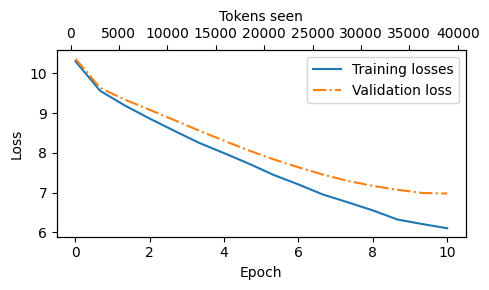

In [136]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

def plot_losses(epochs_seen, tokens_seen, train_losses, val_losses):
    fig, ax1 = plt.subplots(figsize=(5, 3))
    ax1.plot(epochs_seen, train_losses, label="Training losses")
    ax1.plot(
        epochs_seen, val_losses, linestyle="-.", label="Validation loss"
    )
    ax1.set_xlabel("Epoch")
    ax1.set_ylabel("Loss")
    ax1.legend(loc="upper right")
    ax1.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax2 = ax1.twiny()
    ax2.plot(tokens_seen, train_losses, alpha=0)
    ax2.set_xlabel("Tokens seen")
    fig.tight_layout()
    plt.show()

epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
plot_losses(epochs_tensor, tokens_seen, train_losses, val_losses)

## Decoding strategies to control randomness

Now let's generate more original text by applying decoding strategies.

First part involves reviewing the `generate_text_simple` function, the generated token is a selection of the most probable next word to add into a sequence; therefore, the LLM will always output the same token even by running the `generate_text_simple` multiple times.

To produce different tokens each time, one need to look at the **temperature scaling**, a technique that adds a probabilitistic selection process to the next token generation task. Originally, the `generate_text_simple` sampled the token with the highes probability with `torch.argmax`, also known as *greedy decoding*. To generate text with more variety, `argmax` must be replaces with a function that samples from a probability distribution.

In [137]:
model.to("cpu") # If the model was training in a gpu, let's return it to cpu, since evaluation requires less resources
model.eval()

tokenizer = tiktoken.get_encoding("gpt2")
token_ids = generate_text_simple(
    model=model,
    idx=text_to_token_ids("Every effort moves you", tokenizer),
    max_new_tokens=25,
    context_size=GPT_CONFIG_124M['context_length']
)
print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effort moves you the the.
























In [138]:
# This is part of an example, to illustrate the probabilistic sampling
# With a very small vocabulary, generating next-token logits, assuming 
# the starting context "every effort moves you"
vocab = {
    "closer": 0,
    "every": 1,
    "effort": 2,
    "forward": 3,
    "inches": 4,
    "moves": 5,
    "pizza": 6,
    "toward": 7,
    "you": 8,
}
inverse_vocab = {v: k for k, v in vocab.items()}
next_token_logits = torch.tensor(
    [4.51, 0.89, -1.9, 6.75, 1.63, -1.62, -1.89, 6.28, 1.79]
)

In [139]:
# To convert logits into probabilities, the generate_text_simple function uses the softmax function
# to then use the argmax and select the most likely token
probas = torch.softmax(next_token_logits, dim=0)
next_token_id = torch.argmax(probas).item()
print(inverse_vocab[next_token_id])

forward


In [140]:
# To implement a probabilistic sampling process, replace the argmax function to multinomial function
torch.manual_seed(123)
next_token_id = torch.multinomial(probas, num_samples=1).item()
print(inverse_vocab[next_token_id])

toward


In [141]:
# After repeating the same sample 1,000 times, forward is still the most frequent words amoung all others, 
# but now there is a chance other words like closer or toward for being selected
def print_sampled_tokens(probas):
    torch.manual_seed(123)
    sample = [torch.multinomial(probas, num_samples=1).item() for i in range(1_000)]
    sampled_ids = torch.bincount(torch.tensor(sample))
    for i, freq in enumerate(sampled_ids):
        print(f"{freq} x {inverse_vocab[i]}")

print_sampled_tokens(probas)

71 x closer
2 x every
0 x effort
544 x forward
2 x inches
1 x moves
0 x pizza
376 x toward
4 x you


In [142]:
# To further control the distribution and selecction process, introducing the concept temperature scaling,
# That is a division between the logits and a number greater than 0. By having a temperature greater than 1,
# the result will be more uniformly, for temperatures smaller than1, the result will be more confident.
def softmax_with_temperature(logits, temperature):
    scaled_logits = logits / temperature
    return torch.softmax(scaled_logits, dim=0)

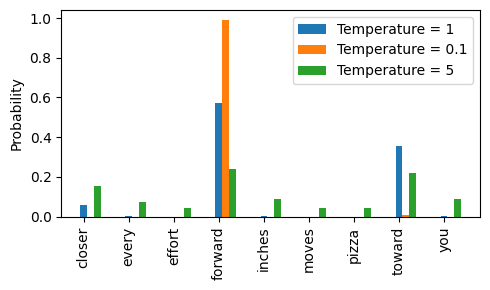

In [143]:
# This graph shows the effect of different temperatures on the word selection.
# Having a temperature of 1 is the same as not using any temperature scaling,
# while a temperature such as 0.1 will result in sharper distributions.
# Likewise, a temperature of 5 results on a more uniform distribution
# where other tokens are selected more often, leading to nonsense.
temperatures = [1, 0.1, 5]
scaled_probas = [softmax_with_temperature(next_token_logits, T) for T in temperatures]
x = torch.arange(len(vocab))
bar_width = 0.15
fig, ax = plt.subplots(figsize=(5,3))
for i, T in enumerate(temperatures):
    rects = ax.bar(x + i * bar_width, scaled_probas[i], bar_width, label=f'Temperature = {T}')

ax.set_ylabel('Probability')
ax.set_xticks(x)
ax.set_xticklabels(vocab.keys(), rotation=90)
ax.legend()
plt.tight_layout()
plt.show()

In [144]:
# The author suggests an exercise
# Using the print_sampled_text_tokens function, scaling the probabilities with the temperature.
# How often is the word pizza sampled in each case?
# Can you think of a faster and more accurate way to determine how often the word pizza is sampled?

# Starting with a temperature of 1, pizza must have a low probability due to its low logit (in this case 0 out of 1,000)
probas = torch.softmax(next_token_logits / 1.0, dim=0)
print("Temperature = 1.0:")
print_sampled_tokens(probas)

# Case 2: Temperature = 0.5 (more peaked)
# Lower temperature exaggerates differences in logits (in this case 0 out of 1,000)
probas = torch.softmax(next_token_logits / 0.5, dim=0)
print("\nTemperature = 0.5:")
print_sampled_tokens(probas)

# Case 3: Temperature = 2.0 (more uniform)
# Higher temperatures makes probabilities more uniform (in this case 4 out of 1,000 ~= 0.4%)
probas = torch.softmax(next_token_logits / 2.0, dim=0)
print("\nTemperature = 2.0:")
print_sampled_tokens(probas)

# To be more efficient, instead of run 1,000 iterations, let's calculate the probability after softmax
# and multiplying by the number of samples
def expected_frequency(logits, temperature, token_id, num_samples=1_000):
    probas = F=torch.softmax(logits / temperature, dim=0)
    return probas[token_id].item() * num_samples

# Expected frequency of "pizza" (token_id=6)
print("Expected frequency of 'pizza':")
print(f"Temp=1.0: {expected_frequency(next_token_logits, 1.0, 6):.1f}")
print(f"Temp=0.5: {expected_frequency(next_token_logits, 0.5, 6):.1f}")
print(f"Temp=2.0: {expected_frequency(next_token_logits, 2.0, 6):.1f}")

Temperature = 1.0:
71 x closer
2 x every
0 x effort
544 x forward
2 x inches
1 x moves
0 x pizza
376 x toward
4 x you

Temperature = 0.5:
5 x closer
0 x every
0 x effort
688 x forward
0 x inches
0 x moves
0 x pizza
307 x toward

Temperature = 2.0:
158 x closer
20 x every
12 x effort
391 x forward
37 x inches
5 x moves
4 x pizza
340 x toward
33 x you
Expected frequency of 'pizza':
Temp=1.0: 0.1
Temp=0.5: 0.0
Temp=2.0: 5.6


The next techinque is called **top-k sampling**, the temperature scaling help to produce a more diverse output, allowing the exploration of more interesting and creative paths in the generation process. However, this approch sometimes leads to grammatically incorrect or completely nonsensical outputs such as `every effort moves you pizza`.

*Top-k sampling* combines with probabilistic sampling and temperatures caling, can improve the text generation results. It restricts the sampled tokens to the top-k most likely tokens and exclude all other tokens from the selection process by masking their probability scores.

Top-k replace all nonselected logits with negative infinity value, such that when computing the softmax values, the probability scores of the non-top-k tokens are 0, and the remaining probabilities sum up to 1.

In [145]:
top_k = 3
top_logits, top_pos = torch.topk(next_token_logits, top_k)
print("Top logits:", top_logits)
print("Top positions:", top_pos)

Top logits: tensor([6.7500, 6.2800, 4.5100])
Top positions: tensor([3, 7, 0])


In [146]:
new_logits = torch.where(
    condition=next_token_logits < top_logits[-1],
    input=torch.tensor(float('-inf')),
    other=next_token_logits
)
print(new_logits)

tensor([4.5100,   -inf,   -inf, 6.7500,   -inf,   -inf,   -inf, 6.2800,   -inf])


In [147]:
topk_probas = torch.softmax(new_logits, dim=0)
print(topk_probas)

tensor([0.0615, 0.0000, 0.0000, 0.5775, 0.0000, 0.0000, 0.0000, 0.3610, 0.0000])


In [148]:
def generate(model, idx, max_new_tokens, context_size, temperature=0.0, top_k=None, eos_id=None):
    for _ in range(max_new_tokens):
        idx_cond = idx[:, -context_size:]
        with torch.no_grad():
            logits = model(idx_cond)

        logits = logits[:, -1, :]
        if top_k is not None:
            top_logits, _ = torch.topk(logits, top_k)
            min_val = top_logits[:, -1]
            logits = torch.where(
                logits < min_val,
                torch.tensor(float('-inf')).to(logits.device),
                logits
            )
        if temperature > 0.0:
            logits = logits / temperature
            probs = torch.softmax(logits, dim=-1)
            idx_next = torch.multinomial(probs, num_samples=1)
        else:
            idx_next = torch.argmax(logits, dim=-1, keepdim=True)

        if idx_next == eos_id:
            break

        idx = torch.cat((idx, idx_next), dim=1)

    return idx

In [149]:
torch.manual_seed(123)
token_idx = generate(
    model=model,
    idx=text_to_token_ids("Every effort moves you", tokenizer),
    max_new_tokens=15,
    context_size=GPT_CONFIG_124M['context_length'],
    top_k=25,
    temperature=1.4
)
print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effort moves you the the.
























In [150]:
# The author suggests an exercise
# Play around with different temperatures and top-k settings. Based on your observations, can you think
# can you think of applications where lower temperature and top-k settings are desired? Likewise, can
# you think of applications where higher temperature and top-k settings are preferred?

In [151]:
# The author suggest an exercise
# What are the different combinations of settings for the generate function to force deterministic behavior,
# that is, disabling the random sampling such that it always produces the same outputs similar to the generate_simple function?

token_idx = generate(
    model=model,
    idx=text_to_token_ids("Every effort moves you", tokenizer),
    max_new_tokens=15,
    context_size=GPT_CONFIG_124M['context_length'],
    top_k=None, # <- Removes top k selection
    temperature=1 # <- fix temperature to 1
)

## Loading and saving model weights in PyTorch

Training an LLM is computationally expensive. Thus, it is important to be able to save the LLM so there is no need to rerun the training process every time a new session is required.

Fortunately, saving a PyTorch model is relatively straightforward. The recommended way is to save a model's `state_dict`, a dictionary mapping each layer to its parameters, using the `torch.save` function.

Loading the model weights into a new `GPTModel` requires the use of `model.load_state_dict` function.

In [152]:
torch.save(model.state_dict(), "model.pth")

In [153]:
model = GPTModel(GPT_CONFIG_124M)
model.load_state_dict(torch.load("model.pth", map_location=device))
model.eval() # <- change to evaluation mode, disabling dropout

<ipython-input-153-7625274b5238>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("model.pth", map_location=device))


GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(256, 768)
  (drop_emb): Dropout(p=0.2, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=False)
        (W_key): Linear(in_features=768, out_features=768, bias=False)
        (W_value): Linear(in_features=768, out_features=768, bias=False)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.2, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.2, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): 

In [154]:
# This will store also information from optimizer. Important, becuase optimizer store additional parameters for each model
# weight. AdamW uses historical data to adjust learning rates for each model parameter dynamically. Without it, the optimizer
# resets, and the model may learn suboptimal or even fail to converge properly, which means it will lose the ability to generate
# coherent text
torch.save(
    {
        "model_state_dict": model.state_dict(),
        "optimizer_state_dict": optimizer.state_dict()
    },
    "model_and_optimizer.pth"
)

In [155]:
# To restore the model and optimizer states, first load the saved data via torch.load and then using load_state_dict method
checkpoint = torch.load("model_and_optimizer.pth", map_location=device)
model = GPTModel(GPT_CONFIG_124M)
model.load_state_dict(checkpoint['model_state_dict'])
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-4, weight_decay=0.1)
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
model.train()

<ipython-input-155-3beb0abfb668>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load("model_and_optimizer.pth", map_location=device)


GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(256, 768)
  (drop_emb): Dropout(p=0.2, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=False)
        (W_key): Linear(in_features=768, out_features=768, bias=False)
        (W_value): Linear(in_features=768, out_features=768, bias=False)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.2, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.2, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): 

## Loading pretrained weights from OpenAI

The previous training shows the fundamentals without the need for expensive time and computational resources. On the other hand, OpenAI openly shared the weights of their GPT-2 models.

OpenAI store its weights on TensorFlow, so the following code will allow 

In [156]:
import urllib.request
url = (
    "https://raw.githubusercontent.com/rasbt/LLMs-from-scratch/main/ch05/01_main-chapter-code/gpt_download.py"
)
filename = url.split("/")[-1]
urllib.request.urlretrieve(url, filename)

('gpt_download.py', <http.client.HTTPMessage at 0x7e85b2339000>)

In [157]:
from gpt_download import download_and_load_gpt2
settings, params = download_and_load_gpt2(
    model_size="124M", models_dir="gpt2"
)

checkpoint: 100%|██████████| 77.0/77.0 [00:00<00:00, 74.9kiB/s]
encoder.json: 100%|██████████| 1.04M/1.04M [00:00<00:00, 3.07MiB/s]
hparams.json: 100%|██████████| 90.0/90.0 [00:00<00:00, 83.2kiB/s]
model.ckpt.data-00000-of-00001: 100%|██████████| 498M/498M [00:41<00:00, 11.9MiB/s]
model.ckpt.index: 100%|██████████| 5.21k/5.21k [00:00<00:00, 5.53MiB/s]
model.ckpt.meta: 100%|██████████| 471k/471k [00:00<00:00, 2.09MiB/s]
vocab.bpe: 100%|██████████| 456k/456k [00:00<00:00, 1.88MiB/s]


In [158]:
# These are the settings from the GPT model, similar to the one created
print("Settings:", settings)
print("Parameter dictionary keys:", params.keys())

Settings: {'n_vocab': 50257, 'n_ctx': 1024, 'n_embd': 768, 'n_head': 12, 'n_layer': 12}
Parameter dictionary keys: dict_keys(['blocks', 'b', 'g', 'wpe', 'wte'])


In [159]:
# Inspecting the weight params...
print(params['wte'])
print("Token embedding weight tensor dimensions:", params['wte'].shape)

[[-0.11010301 -0.03926672  0.03310751 ... -0.1363697   0.01506208
   0.04531523]
 [ 0.04034033 -0.04861503  0.04624869 ...  0.08605453  0.00253983
   0.04318958]
 [-0.12746179  0.04793796  0.18410145 ...  0.08991534 -0.12972379
  -0.08785918]
 ...
 [-0.04453601 -0.05483596  0.01225674 ...  0.10435229  0.09783269
  -0.06952604]
 [ 0.1860082   0.01665728  0.04611587 ... -0.09625227  0.07847701
  -0.02245961]
 [ 0.05135201 -0.02768905  0.0499369  ...  0.00704835  0.15519823
   0.12067825]]
Token embedding weight tensor dimensions: (50257, 768)


In [160]:
# Creating a dictionary of GPTModel configurations will help to load weights and configuration
# based on the GPT model to be used.
model_configs = {
    "gpt2-small (124M)": {"emb_dim": 768, "n_layers": 12, "n_heads": 12},
    "gpt2-medium (355M)": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16},
    "gpt2-large (774M)": {"emb_dim": 1280, "n_layers": 36, "n_heads": 20},
    "gpt2-xl (1558M)": {"emb_dim": 1600, "n_layers": 48, "n_heads": 25}
}

In [161]:
model_name = "gpt2-small (124M)"
NEW_CONFIG = GPT_CONFIG_124M.copy()
NEW_CONFIG.update(model_configs[model_name])

In [162]:
# By default, initializing a GPTModel instance initialize random weights (remember that I modify these so weights are initialized using
# the GPT variant)
# The last step to using OpenAI's model weights is to override these randomw eights with the weights loaded into the params dictionary
NEW_CONFIG.update({'context_length': 1024})
NEW_CONFIG.update({'qkv_bias': True})
gpt = GPTModel(NEW_CONFIG)
gpt.eval()

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(1024, 768)
  (drop_emb): Dropout(p=0.2, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=True)
        (W_key): Linear(in_features=768, out_features=768, bias=True)
        (W_value): Linear(in_features=768, out_features=768, bias=True)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.2, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.2, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Li

In [163]:
def assign(left, right):
    if left.shape != right.shape:
        raise ValueError(f"Shape mismatch. Left: {left.shape}, Right: {right.shape}")
    return torch.nn.Parameter(torch.tensor(right))

In [164]:
import numpy as np

def load_weights_into_gpt(gpt, params):
    gpt.pos_emb.weight = assign(gpt.pos_emb.weight, params['wpe'])
    gpt.tok_emb.weight = assign(gpt.tok_emb.weight, params['wte'])

    for b in range(len(params['blocks'])):
        q_w, k_w, v_w = np.split(
            (params['blocks'][b]['attn']['c_attn'])['w'], 3, axis=-1)
        
        gpt.trf_blocks[b].att.W_query.weight = assign(
            gpt.trf_blocks[b].att.W_query.weight, q_w.T)
        gpt.trf_blocks[b].att.W_key.weight = assign(
            gpt.trf_blocks[b].att.W_key.weight, k_w.T)
        gpt.trf_blocks[b].att.W_value.weight = assign(
            gpt.trf_blocks[b].att.W_value.weight, v_w.T)

        q_b, k_b, v_b = np.split(
            (params['blocks'][b]['attn']['c_attn'])["b"], 3, axis=-1
        )
        
        gpt.trf_blocks[b].att.W_query.bias = assign(
            gpt.trf_blocks[b].att.W_query.bias, q_b.T)
        gpt.trf_blocks[b].att.W_key.bias = assign(
            gpt.trf_blocks[b].att.W_key.bias, k_b.T)
        gpt.trf_blocks[b].att.W_value.bias = assign(
            gpt.trf_blocks[b].att.W_value.bias, v_b.T)

        gpt.trf_blocks[b].att.out_proj.weight = assign(
            gpt.trf_blocks[b].att.out_proj.weight,
            params["blocks"][b]["attn"]["c_proj"]["w"].T)
        gpt.trf_blocks[b].att.out_proj.bias = assign(
            gpt.trf_blocks[b].att.out_proj.bias,
            params["blocks"][b]["attn"]["c_proj"]["b"].T)

        gpt.trf_blocks[b].ff.layers[0].weight = assign(
            gpt.trf_blocks[b].ff.layers[0].weight,
            params["blocks"][b]["mlp"]["c_fc"]["w"].T)
        gpt.trf_blocks[b].ff.layers[0].bias = assign(
            gpt.trf_blocks[b].ff.layers[0].bias,
            params["blocks"][b]["mlp"]["c_fc"]["b"].T)
        gpt.trf_blocks[b].ff.layers[2].weight = assign(
            gpt.trf_blocks[b].ff.layers[2].weight,
            params["blocks"][b]["mlp"]["c_proj"]["w"].T)
        gpt.trf_blocks[b].ff.layers[2].bias = assign(
            gpt.trf_blocks[b].ff.layers[2].bias,
            params["blocks"][b]["mlp"]["c_proj"]["b"].T)

        gpt.trf_blocks[b].norm1.scale = assign(
            gpt.trf_blocks[b].norm1.scale,
            params["blocks"][b]["ln_1"]["g"])
        gpt.trf_blocks[b].norm1.shift = assign(
            gpt.trf_blocks[b].norm1.shift,
            params["blocks"][b]["ln_1"]["b"])

        gpt.trf_blocks[b].norm2.scale = assign(
            gpt.trf_blocks[b].norm2.scale,
            params["blocks"][b]["ln_2"]["g"])
        gpt.trf_blocks[b].norm2.shift = assign(
            gpt.trf_blocks[b].norm2.shift,
            params["blocks"][b]["ln_2"]["b"])

    gpt.final_norm.scale = assign(gpt.final_norm.scale, params['g'])
    gpt.final_norm.shift = assign(gpt.final_norm.shift, params["b"])
    gpt.out_head.weight = assign(gpt.out_head.weight, params['wte'])

In [165]:
load_weights_into_gpt(gpt, params)
gpt.to(device)

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(1024, 768)
  (drop_emb): Dropout(p=0.2, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=True)
        (W_key): Linear(in_features=768, out_features=768, bias=True)
        (W_value): Linear(in_features=768, out_features=768, bias=True)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.2, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.2, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Li

In [166]:
torch.manual_seed(123)
token_ids = generate(
    model=gpt,
    idx=text_to_token_ids("Every effot moves you", tokenizer).to(device),
    max_new_tokens=25,
    context_size=NEW_CONFIG['context_length'],
    top_k=50,
    temperature=1.5
)
print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effot moves you have an equal share for each move from move 11 of step 6; and there is no more need to make a full pass


# Fine-tuning for classification

The most common ways to fine'tune language moldes are *instruction fine-tuning* and *classification fine-tuning*.

Instruction fine-tuning involves training a language model on a set of tasks using specific instructions to improve its ability to understand and execute tasks.

While classification fine-tuning is trained to recognize a specific set of class labels, such as "spam" and "not spam". A limitation is that the model can only predict classes encountered during its training, for example, it can say whether something is "spam" or "not spam", but can't say anything else about the input text.

In constrast to classification fine-tuned model, an instruction fine-tuned model typically can undertake a broader range of tasks. Classification fine-tuned can be seen as highly specialized model than a generalist model that works weel across various tasks.

> Choosing between instruction or classification fine-tuning depends purely on the need. Instruction fine-tuning is best suited for models that need to handle a variety of tasks based on complex user instructions. Classification fine-tuning is ideal for projects requiring precise categorization of data into predefined classes, such as sentiment analysis or spam detection.
>
> While instruction fine-tuning is more versatie, it demands larger datasets and greater computational resources to develop models proficient in various tasks. In contrast, classification fine-tuning requires less data and compute power, but its use is confined to the specific classes on which the model has been trained.

In [167]:
import urllib.request
import zipfile
import os
from pathlib import Path

url = "https://archive.ics.uci.edu/static/public/228/sms+spam+collection.zip"
zip_path = "sms_spam_collection.zip"
extracted_path = "sms_spam_collection"
data_file_path = Path(extracted_path) / "SMSSpamCollection.tsv"

def download_and_unzip_spam_data(
    url, zip_path, extracted_path, data_file_path
):
    if data_file_path.exists():
        print(f"{data_file_path} already exists. Skipping download and extraction.")
        return

    with urllib.request.urlopen(url) as response:
        with open(zip_path, "wb") as out_file:
            out_file.write(response.read())

    with zipfile.ZipFile(zip_path, "r") as zip_ref:
        zip_ref.extractall(extracted_path)

    original_file_path = Path(extracted_path) / "SMSSpamCollection" 
    os.rename(original_file_path, data_file_path)

    print(f"File downloaded and saved as {data_file_path}")

download_and_unzip_spam_data(url, zip_path, extracted_path, data_file_path)

File downloaded and saved as sms_spam_collection/SMSSpamCollection.tsv


In [168]:
import pandas as pd
df = pd.read_csv(
    data_file_path, sep='\t', header=None, names=["Label", "Text"]
)
df

,Label,Text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...
5568,ham,Will ü b going to esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other s..."
5570,ham,The guy did some bitching but I acted like i'd...


In [169]:
# Looking at the label distribution, it's easy to spot that they're not balanced. This could be harmful to the model
# since to get a correct generalization and pattern detection, labels must be balanced
print(df['Label'].value_counts())

Label
ham     4825
spam     747
Name: count, dtype: int64


In [170]:
# An easy way to balance a dataset is by downsampling the overrepresented label (ham), matching the underrepresented label (spam)
def create_balanced_dataset(df):
    num_spam = df[df['Label'] == 'spam'].shape[0]
    ham_subset = df[df['Label'] == 'ham'].sample(num_spam, random_state=123)
    balanced_df = pd.concat([
        ham_subset, df[df['Label'] == 'spam']
    ])
    return balanced_df

balanced_df = create_balanced_dataset(df)
print(balanced_df['Label'].value_counts())

Label
ham     747
spam    747
Name: count, dtype: int64


In [171]:
# Encode labels to be 0 or 1
balanced_df['Label'] = balanced_df['Label'].map({"ham":0, "spam":1})

In [172]:
# To train the model data must be splitted into three datasets, training (70%), validations (10%), test (20%).
# These are common ratios used to train, test and validate classification models.
# The dataset must be randomized so the model doesn't find patterns related to records order. This is  only
# desired when training time series predictions, when order matters.
def random_split(df, train_frac, validation_frac):
    df = df.sample(
        frac=1, random_state=123
    ).reset_index(drop=True)
    train_end = int(len(df) * train_frac)
    validation_end = train_end + int(len(df) * validation_frac)

    train_df = df[:train_end]
    validation_df = df[train_end:validation_end]
    test_df = df[validation_end:]

    return train_df, validation_df, test_df

train_df, validation_df, test_df = random_split(
    balanced_df, 0.7, 0.1
)

In [173]:
train_df.to_csv("train.csv", index=None)
validation_df.to_csv("validation.csv", index=None)
test_df.to_csv("test.csv", index=None)

## Data loader

Using a similar concept of data loader in previous steps of this notebook, the objective is to use a handler to manage text messages of different sizes. To batch these messages as did previously there are two options:

- Truncate all messages to the lenght of the shortest message in the dataset batch. 
- Pad all messages to the lenght of the longest message in the dataset or batch.

First option is computationally cheaper, but may result in significant information loss if the shortest message is smaller than the average or longest message, reducing model performance. The second option preserves the entire content of all message, at the cost of being computationally expensive.

To pad the length of the longest message in the dataset, we add padding tokens to all shorter messages and instead of adding the `<|endoftext|>` text directly to the text messages, a better option is to include only the token.

Now, implementing the a `PyTorch Dataset`, specifying how the data is loaded and processed before instantiating the data loaders.

The `SpamDataset` class indentifies the longest sequence in the training dataset, encodes the text messages, and ensures that all other sequences are padded with a padding token to match the length of the longest sequence.

In [174]:
import tiktoken
tokenizer = tiktoken.get_encoding("gpt2")
print(tokenizer.encode("<|endoftext|>", allowed_special={"<|endoftext|>"}))

[50256]


In [175]:
import torch
from torch.utils.data import Dataset

class SpamDataset(Dataset):
    def __init__(self, csv_file, tokenizer, max_length=None, pad_token_id=50256):
        self.data = pd.read_csv(csv_file)
        self.encoded_texts = [
            tokenizer.encode(text) for text in self.data['Text']
        ] # Encodes all text messages
        
        if max_length is None:
            # Look for the longest encoded sequence and store it
            self.max_length = self._longest_encoded_length()
        else:
            # In case max length is given, all sequence exceding it 
            # are truncated to match the max length.
            self.max_length = max_length

            self.encoded_text = [
                encoded_text[:self.max_length]
                for encoded_text in self.encoded_texts
            ]

        # Pad all sequence to match the max length with the pad_token_id
        self.encoded_texts = [
            encoded_text + [pad_token_id] * (self.max_length - len(encoded_text))
            for encoded_text in self.encoded_texts
        ]

    def __getitem__(self, index):
        # When getting each item in the dataset, this method will
        # result the encoded text plus its label in tensor format.
        encoded = self.encoded_texts[index]
        label = self.data.iloc[index]['Label']
        return (
            torch.tensor(encoded, dtype=torch.long),
            torch.tensor(label, dtype=torch.long)
        )

    def __len__(self):
        return len(self.data)

    def _longest_encoded_length(self):
        max_length = 0
        for encoded_text in self.encoded_texts:
            encoded_length = len(encoded_text)
            if encoded_length > max_length:
                max_length = encoded_length

        return max_length

In [176]:
# The longest sequence show a maximum of 120 tokens
train_dataset = SpamDataset(
    csv_file="train.csv",
    max_length=None,
    tokenizer=tokenizer
)

print(train_dataset.max_length)

120


In [177]:
val_dataset = SpamDataset(
    csv_file="validation.csv",
    max_length=train_dataset.max_length,
    tokenizer=tokenizer
)
test_dataset = SpamDataset(
    csv_file="test.csv",
    max_length=train_dataset.max_length,
    tokenizer=tokenizer
)

In [178]:
from torch.utils.data import DataLoader

# To instantiate DataLoader, previous datasets are used. In previous training, the target
# to predict was the next token, in this case is a label. By using batch_size=8, the data
# loader will create 8 batch with 120 tokens length with the corresponding label of each
# sample

num_workers = 0
batch_size = 8
torch.manual_seed(123)

train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    drop_last=True
)
val_loader = DataLoader(
    dataset=val_dataset,
    batch_size=batch_size,
    num_workers=num_workers,
    drop_last=False
)
test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=batch_size,
    num_workers=num_workers,
    drop_last=False
)

for input_batch, target_batch in train_loader:
    pass

# Printing the input and target batch, one can ensure the output has the expected size.
print("Input batch dimensions:", input_batch.shape)
print("Label batch dimensions:", target_batch.shape)

Input batch dimensions: torch.Size([8, 120])
Label batch dimensions: torch.Size([8])


In [179]:
# The number of batched in each dataset.
print(f"{len(train_loader)} train batches")
print(f"{len(val_loader)} validation batches")
print(f"{len(test_loader)} test batches")

130 train batches
19 validation batches
38 test batches


## Initializing a model with pretrained weights

To prepare a model to predict classification labels, it's requested to load ots weights. As done before, the weights are downloaded and then passed to the created model using the previous built function `load_weights_into_gpt`.

By testing the results, it's easy to see that the model performs well on text predictions, but fails to determine whether a text is spam or not. At this point, the next stage is to fine-tune the model so the results match the expected output.

In [180]:
CHOOSE_MODEL = "gpt2-small (124M)"
INPUT_PROMT = "Every effort moves you"
BASE_CONFIG = {
    "vocab_size": 50257,
    "context_length": 1024,
    "drop_rate": 0.0,
    "qkv_bias": True
}
MODEL_CONFIGS = {
    "gpt2-small (124M)": {"emb_dim": 768, "n_layers": 12, "n_heads": 12},
    "gpt2-medium (355M)": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16},
    "gpt2-larget (774M)": {"emb_dim": 1280, "n_layers": 36, "n_heads": 20},
    "gpt2-xl (1558M)": {"emb_dim": 1600, "n_layers": 48, "n_heads": 25}
}
BASE_CONFIG.update(model_configs[CHOOSE_MODEL])

In [181]:
model_size = CHOOSE_MODEL.split(" ")[-1].lstrip("(").rstrip(")")
settings, params = download_and_load_gpt2(
    model_size=model_size, models_dir="gpt2"
)

model = GPTModel(BASE_CONFIG)
load_weights_into_gpt(model, params)
model.eval()

File already exists and is up-to-date: gpt2/124M/checkpoint
File already exists and is up-to-date: gpt2/124M/encoder.json
File already exists and is up-to-date: gpt2/124M/hparams.json
File already exists and is up-to-date: gpt2/124M/model.ckpt.data-00000-of-00001
File already exists and is up-to-date: gpt2/124M/model.ckpt.index
File already exists and is up-to-date: gpt2/124M/model.ckpt.meta
File already exists and is up-to-date: gpt2/124M/vocab.bpe


GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(1024, 768)
  (drop_emb): Dropout(p=0.0, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=True)
        (W_key): Linear(in_features=768, out_features=768, bias=True)
        (W_value): Linear(in_features=768, out_features=768, bias=True)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.0, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Li

In [182]:
text_1 = "Every effots moves you"
token_ids = generate_text_simple(
    model=model,
    idx=text_to_token_ids(text_1, tokenizer),
    max_new_tokens=15,
    context_size=BASE_CONFIG['context_length']
)
print(token_ids_to_text(token_ids, tokenizer))

Every effots moves you to the next level.

The next level is a level of combat


In [183]:
text_2 = (
    "Is the following text 'spam'? Answer with 'yes' or 'no':"
    " 'You are a winner you have been specially"
    " selected to receive $1000 cash or a $2000 award.'"
)
token_ids = generate_text_simple(
    model=model,
    idx=text_to_token_ids(text_2, tokenizer),
    max_new_tokens=23,
    context_size=BASE_CONFIG['context_length']
)
print(token_ids_to_text(token_ids, tokenizer))

Is the following text 'spam'? Answer with 'yes' or 'no': 'You are a winner you have been specially selected to receive $1000 cash or a $2000 award.'

The following text 'spam'? Answer with 'yes' or 'no': 'You are a winner


## Adding a classification head

To prepare the LLM for classification fine-tune, replace the original output layer which maps 50,257 output layer to a two classes: 0 ("not spam") and 1 ("spam"). By adding a Linear output layer, the Final LayerNorm's input, that is, the 768 hidden units, to only 2 units representing the two classes ("spam" and "not spam").

> It's technically possible to use only a single node output since the model is dealing with a binary classification task. However, it would be required to modify the loss function as discussed in ["Losses Learned - Optimizing Negative Log-Likelihood and Cross-Entropy in PyTorch"](https://mng.bz/NRZ2). Basically, we keep the loss function without altering anything but the output of the network, trying to change the loss function, could lead to a more complex fine-tuning process ot even retraining the whole model so the model's weights adapt to the new desired output.
>
> Moreover, with the pretrained model it's not necessary to fine-tune all model layers. In neural network-based language models, the lower layers generally capture basic language structures and semantics applicable across a wide range of tasks and datasets. So, fine-tuning only the last layer, which are more specific to nuanced linguistic patterns and task-specific features, is often sufficient to adapt the model to new tasks.

In [184]:
# Freeze the whole model (i.e. Make the model nontrainable)
for param in model.parameters():
    param.requires_grad = False

In [185]:
torch.manual_seed(123)
num_classes = 2
model.out_head = torch.nn.Linear(
    in_features=BASE_CONFIG["emb_dim"],
    out_features=num_classes
)

In [186]:
# Make trainable the last transformer block (remember there are 12 of them)
for param in model.trf_blocks[-1].parameters():
    param.requires_grad = True
# Also, make trainable the output layer LayerNorm.
for param in model.final_norm.parameters():
    param.requires_grad = True

In [187]:
inputs = tokenizer.encode("Do you have time")
inputs = torch.tensor(inputs).unsqueeze(0)
print("Input:", inputs)
print("Inputs dimensions:", inputs.shape)

Input: tensor([[5211,  345,  423,  640]])
Inputs dimensions: torch.Size([1, 4])


In [188]:
with torch.no_grad():
    outputs = model(inputs)
print("Outputs:\n", outputs)
print("Outputs dimensions:", outputs.shape)

Outputs:
 tensor([[[-1.5840,  0.9893],
         [-3.7231,  7.4521],
         [-2.2665,  6.6035],
         [-3.5974,  3.9888]]])
Outputs dimensions: torch.Size([1, 4, 2])


> **Why focusing on the last output token**
>
> A short version is that the last output token has the most information of the text sequence. Remember that the attetion mask uses a casual attention mechanism that hides the information sequentially to all tokens except the last one. This makes the last output token to has the most contextual informations from all sequence. Therefore, in a spam classification task, we must focus on this last token since it captures the most information.

## Calculating the classification loss and accuracy

Originally, the model converts the 50,257 outputs into probabilities via the `softmax` function and then returning the position of the highest probability via the `argmax` function. Taking this approach, the model can predict whether a text is "spam" or "not spam" with the only difference that now the model will work with 2-dimensional instead of 50,257-dimensional outputs.

In [189]:
print("Last output token:", outputs[:, -1, :])

Last output token: tensor([[-3.5974,  3.9888]])


In [190]:
probas = torch.softmax(outputs[:, -1, :], dim=-1)
label = torch.argmax(probas)
print("Class label:", label.item())

Class label: 1


In [191]:
logits = output[:, -1, :]
label = torch.argmax(logits)
print("Class label:", label.item())

Class label: 1370


In [192]:
def calc_accuracy_loader(data_loader, model, device, num_batches=None):
    model.eval()
    correct_predictions, num_examples = 0, 0

    if num_batches is None:
        num_batches = len(data_loader)
    else:
        num_batches = min(num_batches, len(data_loader))

    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            input_batch = input_batch.to(device)
            target_batch = target_batch.to(device)

            with torch.no_grad():
                logits = model(input_batch)[:, -1, :]
    
            predicted_labels = torch.argmax(logits, dim=-1)
    
            num_examples += predicted_labels.shape[0]
            correct_predictions += (
                (predicted_labels == target_batch).sum().item()
            )

        else:
            break

    return correct_predictions / num_examples

In [193]:
# Model prediction accuracies are nearly random. At this stage, the model isn't 
# fine-tuned, yet
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

torch.manual_seed(123)
train_accuracy = calc_accuracy_loader(
    train_loader, model, device, num_batches=10
)
val_accuracy = calc_accuracy_loader(
    val_loader, model, device, num_batches=10
)
test_accuracy = calc_accuracy_loader(
    test_loader, model, device, num_batches=10
)

print(f"Train accuracy: {train_accuracy*100:.2f}%")
print(f"Validation accuracy: {val_accuracy*100:.2f}%")
print(f"Test accuracy: {test_accuracy*100:.2f}%")

Train accuracy: 46.25%
Validation accuracy: 45.00%
Test accuracy: 48.75%


In [194]:
# Before begin the fine-tuning, it must be defined the loss functions to optimize during training. 
# Since the objective is to maximize the spam classification accuracy of the model, the usage
# of cross-entropy loss will work as a proxy to maximize accuracy due to classification accuracy is
# not a differentiable function.
def calc_loss_batch(input_batch, target_batch, model, device):
    input_batch = input_batch.to(device)
    target_batch = target_batch.to(device)
    logits = model(input_batch)[:, -1, :]
    loss = torch.nn.functional.cross_entropy(logits, target_batch)
    return loss

In [195]:
def calc_loss_loader(data_loader, model, device, num_batches=None):
    total_loss = 0
    if len(data_loader) == 0:
        return float('nan')
    elif num_batches is None:
        num_batches = len(data_loader)
    else:
        num_batches = min(num_batches, len(data_loader))

    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            loss = calc_loss_batch(
                input_batch, target_batch, model, device
            )
            total_loss += loss.item()
        else:
            break
    return total_loss/num_batches

In [196]:
# Calculating the initial loss for each data set
with torch.no_grad():
    train_loss = calc_loss_loader(
        train_loader, model, device, num_batches=5
    )
    val_loss = calc_loss_loader(val_loader, model, device, num_batches=5)
    test_loss = calc_loss_loader(test_loader, model,  device, num_batches=5)

print(f"Train loss: {train_accuracy*100:.2f}%")
print(f"Validation loss: {val_accuracy*100:.2f}%")
print(f"Test loss: {test_accuracy*100:.2f}%")

Train loss: 46.25%
Validation loss: 45.00%
Test loss: 48.75%


## Fine-tuning the model on supervised data

The training loop to improve the pretrained LLM ability for spam classification is defined as follows:

1. For each training epoch
2. For each batch in training set
3. Reset loss gradients from the previous batch iteration
4. Calculate loss on current batch
5. Backward pass to calculate loss gradient
6. Update model weights using loss gradients
7. Print training and validation set losses
8. Generate sample text for visual inspection (return to step 1)

It mirrors closely the `train_model_simple` function used for pretraining the model. The only distinctions are that this new function track the number of training examples instead of the number of tokens, and it calculates the accuracy after each epoch instead of printing a sample text

In [197]:
def train_classifier_simple(
    model, train_loader, val_loader, optimizer, device, num_epochs, eval_freq, eval_iter):
    train_losses, val_losses, train_accs, val_accs = [], [], [], []
    examples_seen, global_step = 0, -1

    for epoch in range(num_epochs):
        model.train()

        for input_batch, target_batch in train_loader:
            optimizer.zero_grad()
            loss = calc_loss_batch(
                input_batch, target_batch, model, device
            )
            loss.backward()
            optimizer.step()
            examples_seen += input_batch.shape[0]
            global_step += 1

            if global_step % eval_freq == 0:
                train_loss, val_loss = evaluate_model(
                    model, train_loader, val_loader, device, eval_iter
                )
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                print(f"Ep {epoch+1} (Step {global_step:06d}): "
                       f"Train loss {train_loss:.3f}, "
                       f"Val loss {val_loss:.3f}")
        train_accuracy = calc_accuracy_loader(
            train_loader, model, device, num_batches=eval_iter
        )
        val_accuracy = calc_accuracy_loader(
            val_loader, model, device, num_batches=eval_iter
        )

        print(f"Training accuracy: {train_accuracy*100:.2f}% | ", end="")
        print(f"Validation accuracy: {val_accuracy*100:.2f}%")
        train_accs.append(train_accuracy)
        val_accs.append(val_accuracy)

    return train_losses, val_losses, train_accs, val_accs, examples_seen

In [198]:
def eval_model(model, train_loader, val_loader, device, eval_iter):
    model.eval()
    with torch.no_grad():
        train_loss = calc_loss_loader(
            train_loader, model, device, num_batches=eval_iter
        )
        val_loss = calc_loss_loader(
            val_loader, model, device, num_batches=eval_iter
        )
    model.train()
    return trian_loss, val_loss

In [199]:
import time

start_time = time.time()
torch.manual_seed(123)
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5, weight_decay=0.1)
num_epochs = 5

train_losses, val_losses, train_accs, val_accs, examples_seen = \
    train_classifier_simple(
        model, train_loader, val_loader, optimizer, device, 
        num_epochs=num_epochs, eval_freq=50, eval_iter=5
    )
end_time = time.time()
execution_time_minutes = (end_time - start_time) / 60
print(f"Training completed in {execution_time_minutes:.2f} minutes.")

Ep 1 (Step 000000): Train loss 2.155, Val loss 2.394
Ep 1 (Step 000050): Train loss 0.617, Val loss 0.637
Ep 1 (Step 000100): Train loss 0.523, Val loss 0.557
Training accuracy: 70.00% | Validation accuracy: 72.50%
Ep 2 (Step 000150): Train loss 0.560, Val loss 0.488
Ep 2 (Step 000200): Train loss 0.419, Val loss 0.396
Ep 2 (Step 000250): Train loss 0.409, Val loss 0.353
Training accuracy: 82.50% | Validation accuracy: 85.00%
Ep 3 (Step 000300): Train loss 0.334, Val loss 0.320
Ep 3 (Step 000350): Train loss 0.344, Val loss 0.311
Training accuracy: 87.50% | Validation accuracy: 87.50%
Ep 4 (Step 000400): Train loss 0.180, Val loss 0.251
Ep 4 (Step 000450): Train loss 0.171, Val loss 0.150
Ep 4 (Step 000500): Train loss 0.228, Val loss 0.150
Training accuracy: 100.00% | Validation accuracy: 95.00%
Ep 5 (Step 000550): Train loss 0.208, Val loss 0.153
Ep 5 (Step 000600): Train loss 0.093, Val loss 0.079
Training accuracy: 100.00% | Validation accuracy: 97.50%
Training completed in 22.79 m

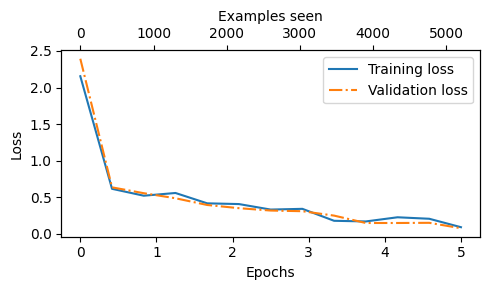

In [200]:
import matplotlib.pyplot as plt

def plot_values(
    epochs_seen, examples_seen, train_values, val_values, label="loss"):
    fig, ax1 = plt.subplots(figsize=(5, 3))

    ax1.plot(epochs_seen, train_values, label=f"Training {label}")
    ax1.plot(
        epochs_seen, val_values, linestyle="-.",
        label=f"Validation {label}"
    )
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel(label.capitalize())
    ax1.legend()

    ax2 = ax1.twiny()
    ax2.plot(examples_seen, train_values, alpha=0)
    ax2.set_xlabel("Examples seen")

    fig.tight_layout()
    plt.savefig(f"{label}-plot.pdf")
    plt.show()

epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
examples_seen_tensor = torch.linspace(0, examples_seen, len(train_losses))

plot_values(epochs_tensor, examples_seen_tensor, train_losses, val_losses)

>**How to select the number of epochs?**
>
>There is no solution, rule or recommendation that sets the correct number of epochs to use for a training. It's more an iterative task that change as you see improvements on the model.
>
>Although, a number of five epochs is usually a good start point. The epochs depends on the dataset and the task's difficulty, by looking at a chart similar to the previous shown you can determine how to improve the model.
>
>If a trend line indicates that the model could improve more, then you can increase the number of epochs. On the other hand, if the model overfits on early stages, you can decrease epochs.

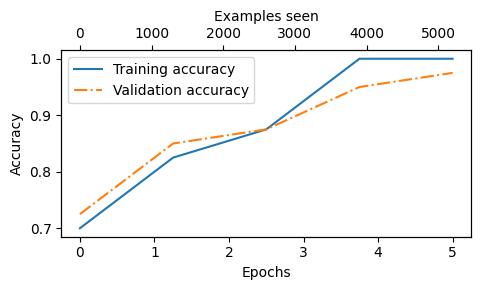

In [201]:
# Classification accuracies
epochs_tensor = torch.linspace(0, num_epochs, len(train_accs))
examples_seen_tensor = torch.linspace(0, examples_seen, len(train_accs))

plot_values(
    epochs_tensor, examples_seen_tensor, train_accs, val_accs, label='accuracy'
)

In [202]:
train_accuracy = calc_accuracy_loader(train_loader, model, device)
val_accuracy = calc_accuracy_loader(val_loader, model, device)
test_accuracy = calc_accuracy_loader(test_loader, model, device)

print(f"Training accuracy: {train_accuracy*100:.2f}%")
print(f"Validation accuracy: {val_accuracy*100:.2f}%")
print(f"Test accuracy: {test_accuracy*100:.2f}%")

Training accuracy: 96.83%
Validation accuracy: 97.32%
Test accuracy: 95.67%


## Using the LLM as a spam classifier



In [203]:
def classify_review(
    text, model, tokenizer, device, max_length=None, pad_token_id=50256):
    model.eval()

    input_ids = tokenizer.encode(text)
    supported_context_length = model.pos_emb.weight.shape[0]

    input_ids = input_ids[:min(max_length, supported_context_length)]

    input_ids += [pad_token_id] * (max_length - len(input_ids))

    input_tensor = torch.tensor(
        input_ids, device=device
    ).unsqueeze(0)

    with torch.no_grad():
        logits = model(input_tensor)[:, -1, :]

    predicted_label = torch.argmax(logits, dim=-1).item()

    return "spam" if predicted_label == 1 else "not spam"

In [204]:
text_1 = (
    "You are a winner you have been specially"
    " selected to receive $1000 cash or a $2000 award."
)

print(classify_review(
    text_1, model, tokenizer, device, max_length=train_dataset.max_length
))

not spam


In [205]:
text_2 = (
    "Hey, just wanted to check if we're still on"
    " for dinner tonight? Let me know!"
)

print(classify_review(
    text_2, model, tokenizer, device, max_length=train_dataset.max_length
))

not spam


In [206]:
# Model saving
torch.save(model.state_dict(), "review_classifier.pth")

In [207]:
# Model loading
model_state_dict = torch.load("review_classifier.pth", map_location=device)
model.load_state_dict(model_state_dict)

<ipython-input-207-573fb017b0a4>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_state_dict = torch.load("review_classifier.pth", map_location=device)


<All keys matched successfully>